# ==========
# = Iteration #2 =
# ==========

## Stage 1: Planning
The tasks for this stage are:
1. Compose the project team
2. Set the research question
3. Schedule all review meeting to ensure iterations are time-boxed.

### 2.1.1. Compose the project team
The project team and Clinical Review Board are CMI and CB.

### 2.1.2. Set the research question
The research question is:

_What is the apparent patient process of HbA1c test and prescriptions, following diagnosis of Type 2 Diabetes, when considering the stratification proposed by he CLinical Review Board?_

HbA1c test values will be represented on a Red-Amber-Yellow-Green scale, and only a sample of the most-common prescription will be explicitly named.
For this question, we will only use `TraMineR` for trajectory mining, and not use process-mining or seqeunce-pattern mining methods R packages.

### 2.1.3. Schedule all review meeting to ensure iterations are time-boxed
CMI and CB will meet in their regular Thursday-morning meeting.

## Stage 2: Extraction
This tasks for this stage are:
1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
2. Obtain data for processing

### 2.2.1. Gather knowledge and insight into the processes under study and the data-generating mechanisms.
Regarding the processes under study, I, the modeller, discuss the project during weekly meetings with an experienced GP who is a professor of primary medical care.
Regarding data-generating mechanisms, I, the modeller, have gathered knowledge from over half a decade experience collaborating with clinicians and patients on research projects about electronic healthcare 
records. 

### 2.2.2. Obtain data for processing
Data have been obtain by agreement via Connected Bradford. Data are queryable via this Jupyter notebook on the GoogleCloudPlatform using AI Vertex Workbench.

Install R packages.

In [1]:
#remotes::install_version("<name>", "<version>")
#install.packages("<name>", dependencies = TRUE, repos='http://cran.rstudio.com/')

#remotes::install_version("dbplyr", "2.3.4")
#library(dbplyr)
#available.packages()['dbplyr',]

In [1]:
#######################
## Install packages. ##
#######################
devtools::install_github("davidsjoberg/ggsankey")
install.packages( "pacman" )
library( pacman )
pacman::p_load(
    bigrquery
    ,tidyverse
    ,readr
    ,tidytext
    ,TraMineR
    ,TraMineRextras
    ,gridExtra
    ,ggsankey
    ,gtable
    ,grid
)

Skipping install of 'ggsankey' from a github remote, the SHA1 (3e171a83) has not changed since last install.
  Use `force = TRUE` to force installation

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



Set and load requisites.

In [3]:
##############################
## Set and load requisites. ##
##############################

# Setup connection to GCP.
project_id = "yhcr-prd-phm-bia-core"
con <- DBI::dbConnect( drv = bigquery(), project = project_id ) %>% suppressWarnings()

# Define R tibbles from GCP tables.
#r_tbl_srcode <- dplyr::tbl( con, dbplyr::in_schema( sql( "CB_FDM_PrimaryCare_V7" ), sql( "tbl_srcode" ) ) )
r_tbl_srcode <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srcode" )
r_tbl_BNF_DMD_SNOMED_lkp <- dplyr::tbl( con, "CB_LOOKUPS.tbl_BNF_DMD_SNOMED_lkp" )
r_tbl_srprimarycaremedication <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srprimarycaremedication" )
r_tbl_srappointment <- dplyr::tbl( con, "CB_FDM_PrimaryCare_V7.tbl_srappointment" )

# Clinical code lists (BNF, SNOMED-CT, etc).
codes_SNOMED_diagnoses_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'nhsd-primary-care-domain-refsets-dmtype2_cod-20200812.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_SNOMED_test_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'opensafely-glycated-haemoglobin-hba1c-tests-3e5b1269.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
codes_BNF_meds_of_interest <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-bnf-section-61-drugs-for-diabetes-207573b7.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_meds_of_interest <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_meds_of_interest ) %>%
    dplyr::select( DMplusD_ProductDescription )
codes_BNF_metformin <-
    readr::read_csv(file = paste0( 'codelists/', 'ciaranmci-metformin-bnf-0601022b0-and-child-bnf-codes-only-43e7d87e.csv'),
                    col_types = cols( code = col_character(), term = col_character() ) )$code
names_metformin_meds <-
    r_tbl_BNF_DMD_SNOMED_lkp %>%
    dplyr::filter( BNF_Code %in% codes_BNF_metformin ) %>%
    dplyr::select( DMplusD_ProductDescription )

# Study start date
date_study_start <- lubridate::ymd('2018-06-01')
date_study_end <- lubridate::ymd('2020-12-31')

# Duration of months after the first prescription that we ignore before studying patterns.
pattern_delay_months <- 0

# Threshold value for the test, which in this case is HbA1c.
val_test_threshold <- 48

# Threshold for the expected interval between subsequent tests.
val_testing_interval <- 5

# Set values for meaningful changes in the values of the test.
val_meaningful_test_improvement <- -10
val_meaningful_test_disimprovement <- 10

# Set window within which to search for repeated (but not repeat) prescriptions.
window_repeated_prescription_months <- 3

# Set number of tests, treatments, or iterations after diagnosis that should be tracked.
n_iterations <- 3

# Set ordering of factors labels for the event variable.
df_event_factor <-
    data.frame(
        event_fct_order =
            factor(
                c( "Test Status = Red", "Test Status = Amber",  "Test Status = Yellow", "Test Status = Green", "Metformin", "Gliclazide", "Empagliflozin", "Other Rx")
                ,levels = c( "Test Status = Red", "Test Status = Amber",  "Test Status = Yellow", "Test Status = Green", "Metformin", "Gliclazide", "Empagliflozin", "Other Rx")
            )
        ,event_colours_order = c( "firebrick1", "darkorange", "gold", "limegreen", "dodgerblue", "plum1", "slateblue1", "grey" )
                
    )

# Set ordering of R.A.M.E. stratification.
df_RAME_factor <-
    data.frame(
        RAME_fct_order =
            factor(
                c("Run", "Adjust", "Monitor", "Escalate")
                ,levels = c("Run", "Adjust", "Monitor", "Escalate")
            )
        ,RAME_colours_order = c( "plum1", "cornflowerblue", "lightcoral", "purple4" )
    )

# Set ordering of TandP stratification.
df_TandP_factor <-
    data.frame(
        TandP_fct_order =
            factor(
                c( 1:16, 0 )
                ,levels = c( 1:16, 0)
            )
        ,TandP_colours_order =
                c(
                    "red" # 1: Test status == Red & Zero prescriptions
                    ,"firebrick3" # 2: Test status == Red & One prescriptions
                    ,"firebrick4" # 3: Test status == Red & Two prescriptions
                    ,"darkred" # 4: Test status == Red & Three prescriptions

                    ,"orange" # 5: Test status == Amber & Zero prescriptions
                    ,"darkorange2" # 6: Test status == Amber & One prescriptions
                    ,"darkorange3" # 7: Test status == Amber & Two prescriptions
                    ,"darkorange4" # 8: Test status == Amber & Three prescriptions

                    ,"yellow" # 9: Test status == Yellow & Zero prescriptions
                    ,"gold2" # 10: Test status == Yellow & One prescriptions
                    ,"gold3" # 11: Test status == Yellow & Two prescriptions
                    ,"gold4" # 12: Test status == Yellow & Three prescriptions

                    ,"green" # 13: Test status == Yellow & Zero prescriptions
                    ,"chartreuse2" # 14: Test status == Yellow & One prescriptions
                    ,"chartreuse3" # 15: Test status == Yellow & Two prescriptions
                    ,"chartreuse4" # 16: Test status == Yellow & Three prescriptions

                    ,"grey" # 0 = Error
                )
    )

Define cohort.

In [4]:
####################
## Define cohort. ##
####################
# The cohort is defined as records that include a diagnosis for Type 2 Diabetes Mellitus (T2DM)
# and a prescription for metformin as the only diabetic medication for the first prescription.
# The following queries create this list of records that are within the Connected Bradford primary
# care table.
#
# Select records from primary care that have a clinical code for a T2DM diagnosis. Include a column
# showing the earliest date of diagnosis. Filter for within the study period.
#
ppl_with_T2DM_diagnoses <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_diagnoses_of_interest ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::summarise( date_diagnosis = min( dateevent, na.rm = TRUE ) ) %>%
    dplyr::select( person_id, date_diagnosis ) %>%
    dplyr::filter( dplyr::between(date_diagnosis, date_study_start, date_study_end) ) %>%
    dplyr::ungroup()

Retrieve dates of prescriptions that followed diagnosis.

In [5]:
qry_log_prescription <-
########################################################################################################
## Select list of person IDs that have a metformin prescription as their first diabetic prescription. ## 
########################################################################################################
    # Select from the medication table the records for those patients who have a diagnosis.
    ppl_with_T2DM_diagnoses %>%
    dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>%
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    # Filter for records after the date of diagnosis.
    ######dplyr::filter( dateevent >= date_diagnosis ) %>%
    # Extract the first prescription.
    dplyr::group_by( person_id ) %>%
    dplyr::summarise( date_first_prescription = min( dateevent, na.rm = TRUE ) ) %>%
    dplyr::ungroup() %>%
    # Re-join to the original table to get the name of the medication.
    dplyr::left_join( r_tbl_srprimarycaremedication, by = join_by( person_id, date_first_prescription == dateevent ) ) %>%
    dplyr::select( person_id, date_first_prescription, nameofmedication, isrepeatmedication, medicationquantity, medicationdosage ) %>%
    dplyr::distinct() %>%
    # Use an inner join to filter these first prescriptions for the metformin medications, only.
    dplyr::inner_join( names_metformin_meds, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>%
    dplyr::distinct() %>%
    # Select the required fields.
    dplyr::select( person_id, date_first_prescription )

##############################################################
## Retrieve dates of prescriptions that followed diagnosis. ##
##############################################################
# Note: If more than one medication was prescribed on the same day, then they are considered
#       to be the i-th and i+1-th prescription, ordered alphabetically. This will manifest
#       as two of the `date_next_prescription_*` fields having the same date, and one of the
#       `interval_prescp_to_prescp_*` fields correctly showing 0 days between the prescriptions.
#
qry_log_prescription_longFormat <-
    qry_log_prescription %>%
    # Join to medications table.
    dplyr::inner_join( r_tbl_srprimarycaremedication, by = join_by( person_id ) ) %>%
    # Select every record that has a prescription for any diabetes medication.
    dplyr::inner_join( names_meds_of_interest, by = join_by( nameofmedication == DMplusD_ProductDescription ) ) %>% 
    # Filter for records after the date of diagnosis.
    dplyr::left_join( ppl_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
    ######dplyr::filter( dateevent >= date_diagnosis ) %>%
    # Extract the required fields.
    dplyr::select( person_id, dateevent, nameofmedication, date_first_prescription ) %>%
    # Filter for tests that were done after the pattern start date.
    dplyr::group_by( person_id ) %>%
    dplyr::filter(
        dateevent > sql(paste0( 'DATETIME_ADD( date_first_prescription, INTERVAL ', pattern_delay_months, ' MONTH )') )
    ) %>% 
    # Remove `date_first_prescription` because it is no longer needed.
    dplyr::select( - date_first_prescription ) %>%
    dplyr::distinct() %>%
    # Filter for however many subsequent prescriptions were specified in `n_iteraions`, then number them.
    dbplyr::window_order( person_id, dateevent, nameofmedication ) %>% 
    dplyr::filter( row_number() <= n_iterations ) %>% 
    dplyr::mutate( event_name = paste0( "prescription_", row_number() ) ) %>% 
    # Rename columns (the hacky way).
    dplyr::mutate(
        start_dttm = dateevent
        ,event_value = nameofmedication
    ) %>%
    dplyr::select( -c( dateevent, nameofmedication ) ) %>% 
    # Set the end time each prescription as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dbplyr::window_order( person_id, start_dttm ) %>%
    dplyr::mutate(
        end_dttm = dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( end_dttm )
        ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
    ) %>%
    dplyr::ungroup() %>%
    suppressWarnings()

df_log_prescription_wideFormat <-
    qry_log_prescription_longFormat %>%
    dplyr::mutate_at( .vars = vars( event_name ), .funs = funs( gsub("prescription_", "prescp", . ) ) ) %>%
    tidyr::pivot_wider(
        names_from = event_name
        ,values_from = c( start_dttm, event_value )
        , names_sort = TRUE) %>%
    dplyr::ungroup() %>%
    suppressWarnings()

Retrieve dates of tests that followed diagnosis.

In [6]:
# Retrieve the test result immediately before diagnosis.
test_value_before_diagnosis <-
    r_tbl_srcode %>%
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest) %>%
    dplyr::select( person_id, dateevent, numericvalue ) %>%
    dplyr::inner_join( ppl_with_T2DM_diagnoses, by = join_by( person_id ) ) %>%
    # Choose tests before the date of diagnosis.
    #####dplyr::filter( dateevent <= ( date_diagnosis + lubridate::days( 1 ) ) ) %>%
    # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
    dplyr::filter( numericvalue != "0" ) %>%
    # Filter for the latest test before diagnosis.
    dplyr::group_by( person_id ) %>%
    dplyr::filter( dateevent == max( dateevent ) ) %>%
    # Filter for the largest score because, sometimes, a patient has two tests on the same latest date, one of which seems spuriously low.
    dplyr::filter( as.numeric(numericvalue) == max( as.numeric(numericvalue) ) ) %>%
    dplyr::ungroup() %>%
    # Tidy up the selection.
    dplyr::select( - date_diagnosis ) %>%
    dplyr::distinct()


######################################################
## Retrieve dates of tests that followed diagnosis. ##
######################################################
qry_log_test_longFormat <- 
    r_tbl_srcode %>%
    # Filter records for only those that refer to the test of interest.
    dplyr::filter( snomedcode %in% codes_SNOMED_test_of_interest ) %>% 
    # Filter for only those patients that we already identified in our prescription table. Include the date of first prescripion.
    dplyr::inner_join( qry_log_prescription %>% dplyr::select( person_id, date_first_prescription )
                      ,by = join_by( person_id )
    ) %>%
    # Extract the required fields.
    dplyr::select( person_id, dateevent, numericvalue, date_first_prescription ) %>%
    # Filter out test scores of 0, which are expected to be data entry anomalies, given my selection of columns.
    dplyr::filter( numericvalue != "0" ) %>%
    # Filter for tests that were done after the pattern start date.
    dplyr::group_by( person_id ) %>%
    dplyr::filter(
        dateevent > sql(paste0( 'DATETIME_ADD( date_first_prescription, INTERVAL ', pattern_delay_months, ' MONTH )') )
    ) %>%
    dplyr::ungroup() %>%
    # Remove `date_first_prescription` because it is no longer needed.
    dplyr::select( - date_first_prescription ) %>% 
    # Rename columns (the hacky way).
    dplyr::mutate(
        start_dttm = dateevent
        ,event_value_numeric = numericvalue
    ) %>% 
    dplyr::select( -c( dateevent, numericvalue ) ) %>%
    # Include each person's date of diagnosis.
    dplyr::collect() %>%
    dplyr::group_by( person_id ) %>%
    dplyr::group_modify(~ add_row( .x, .before = 0 ), .by = person_id ) %>%
    dplyr::left_join( ppl_with_T2DM_diagnoses %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate(
        start_dttm = if_else( is.na( start_dttm ), date_diagnosis , start_dttm )
    ) %>%
    # Filter for records after the date of diagnosis.
    dplyr::filter( start_dttm >= date_diagnosis ) %>% 
    # Filter for however many subsequent tests were specified in `n_iteraions`, then number them.
    dplyr::distinct() %>%
    dplyr::group_by( person_id ) %>% 
    dplyr::arrange( start_dttm ) %>% 
    dplyr::filter( row_number() <= n_iterations ) %>%
    dplyr::mutate( event_name = paste0( "test_", row_number() - 1 ) ) %>% 
    dplyr::ungroup() %>% 
    # Include each person's date of test result just before diagnosis, and use this as the test result for the diagnosis.
    dplyr::left_join( test_value_before_diagnosis %>% collect(), by = join_by( person_id ) ) %>%
    dplyr::mutate(
        event_name = if_else( event_name == "test_0", "diagnosis", event_name )
        ,event_value_numeric = if_else( is.na( event_value_numeric ), numericvalue, event_value_numeric )
    ) %>% 
    dplyr::select( - c( date_diagnosis, numericvalue, dateevent ) ) %>%
    # Set the end time each test as the start time of the previous one.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    dplyr::mutate(
        end_dttm = lead( start_dttm )
    ) %>% 
    ## If the test is the final test, make the end time the start time
    #dplyr::mutate_at(
    #    .vars = vars( end_dttm )
    #    ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
    #) %>%
    dplyr::mutate_at( .vars = vars( event_value_numeric ), .funs = funs( as.numeric ) ) %>%
    # Convert the numeric test values into labels.
    dplyr::mutate(
        event_value = dplyr::case_when(
            event_value_numeric > 70 ~ "Test Status = Red"
            ,event_value_numeric > 58  ~ "Test Status = Amber"
            ,event_value_numeric > 48 ~ "Test Status = Yellow"
            ,TRUE ~ "Test Status = Green"
            )
    ) %>%
    # Tidy up.
    dplyr::ungroup() %>%
    dplyr::select( - event_value_numeric ) %>%
    dplyr::distinct() %>%
    dplyr::arrange(person_id, start_dttm) %>%
    suppressWarnings() 

## Convert to wide format, if ever needed.
#qry_log_test_wideFormat <-
#    qry_log_test_longFormat %>%
#    tidyr::pivot_wider(
#        names_from = event_name
#        ,values_from = c( start_dttm, event_value )
#        ,names_sort = TRUE)

Append the prescriptions and tests dataframe logs.

In [7]:
df_log_PandT_longFormat <-
    qry_log_prescription_longFormat %>%
    dplyr::collect() %>%
    dplyr::union_all( qry_log_test_longFormat ) %>%
    dplyr::ungroup() %>%
    dplyr::arrange( person_id, start_dttm ) #%>% 
    ## Add the syntax that is below if you want the `end_dttm` variable that
    ## to be recalculated for the combined and ordered tests-and-prescrpitions.
    ## Otherwise, the `end_dttm` value for a given event is the `start_dttm` of
    ## the next test if the given event is a test, but is of the next prescription
    ## if the given event is a prescrition
    #dplyr::group_by( person_id ) %>%
    #dplyr::mutate_at(
    #    .vars = vars( end_dttm )
    #    ,.funs = funs(
    #        dplyr::if_else( event_name == "diagnosis", start_dttm, lead( start_dttm ) )
    #    )
    #) %>%
    #dplyr::mutate_at(
    #    .vars = vars( end_dttm )
    #    ,.funs = funs( dplyr::if_else( is.na( end_dttm ), start_dttm, end_dttm ) )
    #) %>%
    #dplyr::ungroup() %>%
    #suppressWarnings()

#df_log_PandT_wideFormat <-
    #df_log_PandT_longFormat %>%
    #tidyr::pivot_wider(
    #    names_from = event_name
    #    ,values_from = c( start_dttm, event_value )
    #    ,names_sort = TRUE)

## Stage 3: Data processing
This tasks for this stage are:
1. Assess data quality
2. Format data for study

### 2.3.1. Assess data quality
I will not assess data quality for this illustrative example. Proper project should always assess data quality, perhaps using [Weiskopf and Weng's 3X3 DQA](https://www.sci-hub.wf/10.1136/amiajnl-2011-000681).

### 2.3.2. Format data for study
I will use the `bupaR` package in R for process mining. The data needs to be in the format of an activity log. The easiest way to create the activity-log object is to make a dataframe with a row for every event, and columns for person_id, event_name, start_dttm, end_dttm. I then pass this dataframe to `bupaR::activityLog()` and specify the key arguments.

I will use the `arulesSequences` package in R for sequence pattern mining. The data needs to be in the format of a transactions object. The easiest way to create the transactions object is to rename some columns of the long-format dataframe, cast is as a transcations object, then insert the metadata.

I will also use the `TraMineR` package in R for sequence pattern mining. The data needs to be in the format of state-sequence object. The easiest way to create the state-sequence object is to use the SQL-extracted time series to define a time-series object, which can then be converted into an STS object using `TraMineRextras::TSE_to_STS()`.

Now, I create the simplified dataframe object from the first iteration (i.e. the SQL-extracted dataframe to only focus on a handful of medications because this is only an example).

In [8]:
# Simplify the event names and values.
df_log_PandT_longFormat_simplified <-
    df_log_PandT_longFormat %>%
    # Remove the numbers in the event name.
    dplyr::mutate_at(
        .vars = vars( event_name )
        ,.funs = ~ gsub( "_[0-9]", "", . )
    ) %>%
    # Group medications.
    dplyr::mutate_at(
        .vars = vars( event_value )
        ,.funs = ~case_when(
            . %in% ( names_metformin_meds %>% dplyr::pull() ) ~ "Metformin"
            ,stringr::str_detect(., "Gliclazide " ) ~ "Gliclazide"
            ,stringr::str_detect(., "Empagliflozin " ) ~ "Empagliflozin"
            ,. %in% c("Test Status = Red", "Test Status = Amber", "Test Status = Yellow", "Test Status = Green") ~ .
            ,TRUE ~ "Other Rx"
        )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( event_value )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    suppressWarnings()

Before I can beging analysing the data, I need to define the strata proposed by the Clinical Review Board. The two stratifications were:
- R.A.M.E.: Four strata defined by combinations of {'Expected', 'Shorter-than-expected'} testing intervals and {'No observed change', 'Observed change'} in prescriptions. The R.A.M.E. acronym derives from the four strata: (0,0)-Run; (0,1)-Adjust; (1,0)-Monitor; (1,1)-Escalate.
- test-and-poly: Twelve strata defined by combinations of the test statuses and whether the patient is on one, two or three medications simulatneously.

The first thing I do is to add a variable that indicates the patient-specific test interval. This will be handy for bounding the variables I need to create.

In [9]:
# Create a variable that indicates patient-specific test interval.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified %>%
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    dplyr::mutate(
        idx_test_interval = 0 + cumsum( stringr::str_detect( event_value, pattern = "Test" ) )
    ) %>% 
    dplyr::ungroup() %>%
    # Remove any record with `idx_test_interval` == 0, which indicates no tests on record.
    dplyr::filter( idx_test_interval != 0 ) %>%
    dplyr::distinct()

__R.A.M.E. stratification__

The two components of this stratification are the testing interval and the change in prescription. The testing interval requries me to create a variable indicating that the inter-test duration was either less than or more than 5 months. The change in prescription requires me to create a variable indicating whether the prescriptions before and after an index test event are the same.

The first thing is to calculate the inter-test duration.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


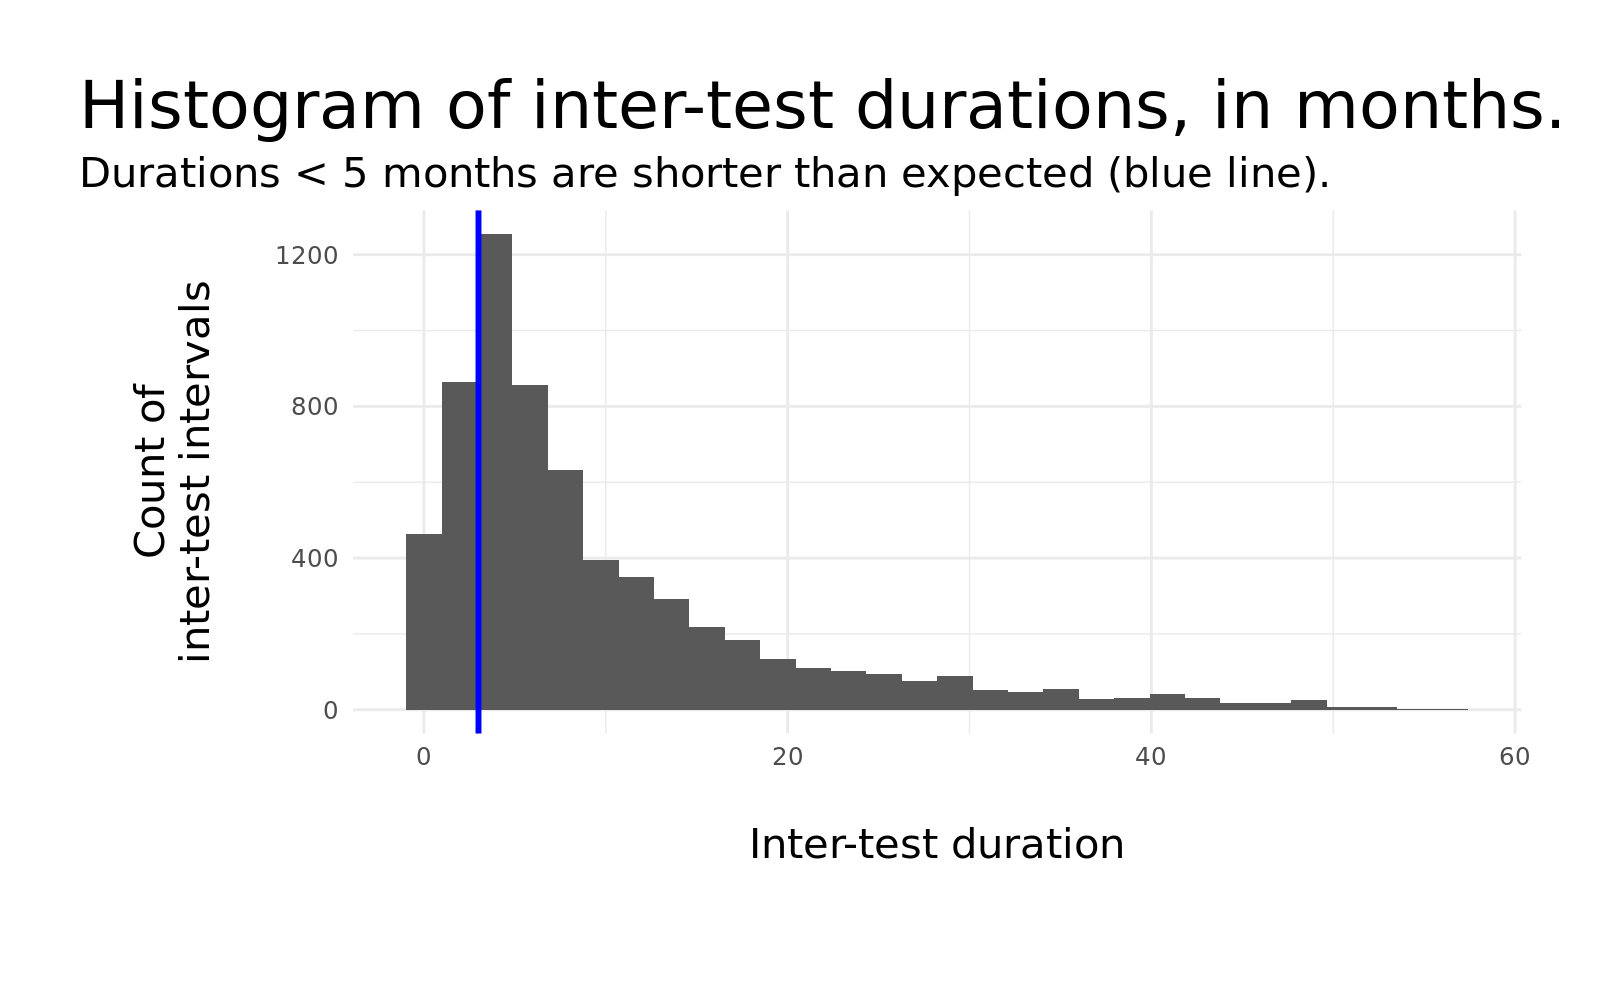

In [10]:
df_inter_test_duration <-
    qry_log_test_longFormat %>%
    # Calculate the duration between each test and the next.
    dplyr::mutate(
        inter_test_duration_cont =
            lubridate::time_length(
                ( end_dttm - start_dttm )
                ,unit = "months"
            )
    ) %>%
    # If the event is a diagnosis, then I need to calculate the inter-test duration in a different way.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    dplyr::mutate_at(
        .vars = vars( inter_test_duration_cont )
        ,.funs = funs(
            if_else(
                event_name == "diagnosis"
                ,lubridate::time_length( ( lead( start_dttm ) - start_dttm ), unit = "months" )
                ,inter_test_duration_cont
            )
        )
    ) %>%
    dplyr::ungroup() %>%
    # Make any same-day tests or anomalies = NA.
    dplyr::mutate_at(
        .vars = vars( inter_test_duration_cont )
        ,.funs = funs( if_else( inter_test_duration_cont == 0, NA_real_, inter_test_duration_cont ) )
    ) %>%
    # Create a discretised version of the inter-test duration variable.
    dplyr::mutate(
        inter_test_duration_discr =
            if_else(
                inter_test_duration_cont < val_testing_interval
                ,"Shorter than expected"
                ,"As expected"
            )
    ) %>%
    # Make any same-day tests or anomalies = NA.
    dplyr::mutate_at(
        .vars = vars( inter_test_duration_discr )
        ,.funs = funs( if_else( inter_test_duration_cont == 0, NA_character_, inter_test_duration_discr ) )
    ) %>%
    # Tidy up.
    dplyr::filter( !is.na( inter_test_duration_cont ) ) %>%
    arrange( person_id, start_dttm ) %>%
    dplyr::select( c( person_id, start_dttm
                     ,inter_test_duration_cont, inter_test_duration_discr ) ) %>% 
    dplyr::distinct() %>%
    suppressWarnings()

# Plotting.
options( repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 200 )

df_inter_test_duration %>%
dplyr::filter( inter_test_duration_cont > 0 ) %>%
ggplot() +
geom_histogram( aes( x = inter_test_duration_cont ) ) +
geom_vline( xintercept = 3, color = "blue", size = 1) +
labs(
    title = "Histogram of inter-test durations, in months."
    ,subtitle = paste0("Durations < ", val_testing_interval, " months are shorter than expected (blue line).")
    ,x = "Inter-test duration"
    ,y = "Count of\ninter-test intervals"
) +
theme_minimal() +
theme(
    title = element_text( size = 20 )
    ,plot.subtitle = element_text( size = 15 )
    ,axis.title = element_text( size = 15 )
    ,plot.title.position = 'plot'
    ,plot.margin = unit( c(1, 1, 1, 1), "cm")
    ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
    ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
    )

# Add the new variable to the dataframe.
df_log_PandT_longFormat_simplified_StrataLabels <-
    # Join the variable indicating the inter-test duration.
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_inter_test_duration
        ,by = join_by( person_id, start_dttm )
        ,relationship = "many-to-many"
        # The `relationship` argument is needed because a warning is raised happens for the situations
        # where multiple prescriptions are given on the same day.
    ) %>%
    # Fill in the values of the inter-test variables into subsequent rows until a new value is given.
    dplyr::group_by( person_id ) %>%
    dplyr::arrange( start_dttm ) %>%
    tidyr::fill( inter_test_duration_cont ) %>%
    tidyr::fill( inter_test_duration_discr ) %>%
    dplyr::ungroup()

Next, I need to make the variable that indicates whether the prescription has changed since the previous interval.

My plan is to:
1. separate tets from prescriptions from `event_value` into two columns.
2. `tidyr::fill()` the test column.
3. `tidyr::pivot_wider()` the prescriptions based on the test column, grouped by `person_id`. The intention is to have one row for each test-interval start, with columns for each drug.
4. combine all the drug columns into a vector, for each row.
5. `base::setdiff()` each row with the next to see if anything changed.



In [11]:
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # Create new columns that contain either the test events or the prescription events.
    dplyr::select( person_id, start_dttm, event_value, idx_test_interval ) %>%
    dplyr::mutate(
        tempCol_tests = if_else( stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
    ) %>%
    dplyr::mutate(
        tempCol_prescrps = if_else( !stringr::str_detect( event_value, pattern = "Test"), event_value, NA_character_ )
    ) %>%
    # Fill the test column until a new value is given.
    dplyr::arrange( person_id, start_dttm ) %>%
    tidyr::fill( tempCol_tests ) %>%
    # Tidy away unecessary columns.
    dplyr::select( - c( event_value, start_dttm ) ) %>%
    # Remove repeated prescriptions within an inter-test period.
    dplyr::distinct() %>%
    # Pivot wider so that each row represents an inter-test period.
    dplyr::group_by( person_id, tempCol_tests ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    tidyr::pivot_wider(
        names_from = rn
        ,values_from = tempCol_prescrps
        ) %>% 
    # List-concatonate the repeated prescriptions into one string
    tidyr::unite(
        col = "meds_set"
        ,dplyr::select(
            .
            ,- c('person_id', 'tempCol_tests', 'idx_test_interval')
        ) %>% colnames()
        ,sep = ","
        ,na.rm = TRUE
    ) %>%
    # Check subsequent rows for a match.
    dplyr::group_by( person_id ) %>% 
    dplyr::mutate( prev_meds_set = lag( meds_set ) ) %>%
    dplyr::ungroup() %>%
    dplyr::mutate_at(
        .vars = vars( meds_set, prev_meds_set )
        ,.funs = funs( strsplit( ., ',') )
    ) %>% 
    dplyr::rowwise() %>%
    dplyr::mutate(
        new_meds =
            if_else(
                is.na( prev_meds_set[1] )
                ,"",
                toString( setdiff( meds_set, prev_meds_set ) ) 
                ) %>% nchar() != 0
    ) %>%
    dplyr::ungroup() %>%
    suppressWarnings() %>%
    # Join the `new_meds` column to the original dataframe.
    dplyr::select( person_id, idx_test_interval, new_meds ) %>%
    dplyr::right_join(
        df_log_PandT_longFormat_simplified_StrataLabels
        ,by = join_by( person_id, idx_test_interval )
    )

The final step is to combine the two components of the stratification's definition into a single variable called RAME.

In [12]:
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::mutate(
        RAME =
            dplyr::case_when(
                ( inter_test_duration_discr == "As expected" & new_meds == FALSE ) ~ "Run"
                ,( inter_test_duration_discr == "As expected" & new_meds == TRUE ) ~ "Adjust"
                ,( inter_test_duration_discr == "Shorter than expected" & new_meds == FALSE ) ~ "Monitor"
                ,( inter_test_duration_discr == "Shorter than expected" & new_meds == TRUE ) ~ "Escalate"
                ,TRUE ~ NA_character_
            )
    ) %>%
    # Set as a factor datatype and order the factors.
    dplyr::mutate_at(
        .vars = vars( RAME )
        ,.funs = funs( factor( ., levels =  ) )
    ) %>%
    suppressWarnings()

__T-and-P stratification__

The two components of this stratification are the test status, T, and the degree of polypharmacy in the previous inter-test interval, P. The test status is already encoded in the `event_value` variable but will require some processing. The degree of polypharmacy will require me to count the unique medication names in the `event_value` column that exists between testing events.

Firstly, I add a column that indicates the count of unique medications prescribed in inter-test intervals.

In [13]:
# Add a column that indicates the count of unique medications prescribed in inter-test intervals.
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::left_join(
        df_log_PandT_longFormat_simplified_StrataLabels %>%
        dplyr::filter( !stringr::str_detect( event_value, pattern = "(Test)" ) ) %>%
        dplyr::group_by( person_id, idx_test_interval ) %>%
        dplyr::summarise( n_meds_per_test_interval = n_distinct( event_value ) ) %>%
        dplyr::ungroup() %>%
        dplyr::filter( idx_test_interval != 0 )
        ,by = join_by( person_id, idx_test_interval )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( n_meds_per_test_interval )
        ,.funs = funs( if_else( stringr::str_detect( event_value, pattern = "(Test)" ), NA_integer_, n_meds_per_test_interval ) )
    ) %>%
    suppressWarnings()

`summarise()` has grouped output by 'person_id'. You can override using the
`.groups` argument.


Next, I add a column indicating the most-recent test value.

In [14]:
# Create vector of test statuses.
test_status_rollover <- vector( mode = 'character', length = nrow( df_log_PandT_longFormat_simplified_StrataLabels ) )
for (i in 1:nrow( df_log_PandT_longFormat_simplified_StrataLabels ) )
    {
    # Focus on the value in the row of interest.
    val_i <- df_log_PandT_longFormat_simplified_StrataLabels$event_value[ i ]
    
    # Extract the test status or copy from previous.
    if ( stringr::str_detect( val_i, pattern = "(Test)" ) )
        {
        test_status_rollover[i] <- stringr::str_extract( val_i, '\\b\\w+$')
    } else {
        test_status_rollover[i] <-
        ifelse(
            ( df_log_PandT_longFormat_simplified_StrataLabels$person_id[ i ] !=
                 df_log_PandT_longFormat_simplified_StrataLabels$person_id[ i-1 ] )
            ,stringr::str_extract( val_i, '\\b\\w+$')
            ,test_status_rollover[ i-1 ] )
         
    } # End IF
} # End FOR

# Add column of test statuses.
df_log_PandT_longFormat_simplified_StrataLabels <- 
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    tibble::add_column( as.data.frame( test_status_rollover )
        )


Finally, I create the variable indicating the test-and-poly stratification by combining the test status with the variable indicating the count of unique medications prescribed in inter-test intervals (i.e. with `n_meds_per_test_interval`). The possible values of the test-and-poly stratification variable are:

In [15]:
TandP_display_table <-
    data.frame(
        Value = c( 1:16, 0)
        ,`Test component` = c( rep( c( 'Test Status = Red', 'Test Status = Amber', 'Test Status = Yellow', 'Test Status = Green'), each = 4 ), 'Error' )
        ,`Polypharmacy component` = c( rep( c( 'Zero', 'One', 'Two', '> Two' ), times = 4 ), 'Error' )
    )
TandP_display_table

Value,Test.component,Polypharmacy.component
<dbl>,<chr>,<chr>
1,Test Status = Red,Zero
2,Test Status = Red,One
3,Test Status = Red,Two
4,Test Status = Red,> Two
5,Test Status = Amber,Zero
6,Test Status = Amber,One
7,Test Status = Amber,Two
8,Test Status = Amber,> Two
9,Test Status = Yellow,Zero


In [16]:
df_log_PandT_longFormat_simplified_StrataLabels <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    # The ordering of the my dplyr::case_when() arguments might seem odd at first.
    # This is because the dplyr::case_when() function applies its arguments
    # sequentially. I check the complicated scenarios for each test status before
    # checking the scenario where a test status is given but there is no value
    # for `n_meds_per_test_interval`.
    dplyr::mutate(
        TandP = dplyr::case_when(
            
            ( test_status_rollover == "Red" ) & ( n_meds_per_test_interval == 1 ) ~ 2
            ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval == 2 ) ~ 3
            ,( test_status_rollover == "Red" ) & ( n_meds_per_test_interval > 2 ) ~ 4
            ,( test_status_rollover == "Red" ) ~ 1

            
            ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval == 1 ) ~ 6
            ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval == 2 ) ~ 7
            ,( test_status_rollover == "Amber" ) & ( n_meds_per_test_interval > 2 ) ~ 8
            ,( test_status_rollover == "Amber" ) ~ 5

            
            ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval == 1 ) ~ 10
            ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval == 2 ) ~ 11
            ,( test_status_rollover == "Yellow" ) & ( n_meds_per_test_interval > 2 ) ~ 12
            ,( test_status_rollover == "Yellow" ) ~ 9

            
            ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval == 1 ) ~ 14
            ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval == 2 ) ~ 15
            ,( test_status_rollover == "Green" ) & ( n_meds_per_test_interval > 2 ) ~ 16
            ,( test_status_rollover == "Green" ) ~ 13

            ,TRUE ~ 0
        )
    ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate_at(
        .vars = vars( TandP )
        ,.funs = funs( if_else( TandP == 0, lead( TandP ), TandP ) )
    ) %>%
    dplyr::ungroup()  %>%
    # Set as a factor datatype and order the factors.
    dplyr::mutate_at(
        .vars = vars( TandP )
        ,.funs = funs( factor( ., levels = c(0, 1:16) ) )
    ) %>%
    suppressWarnings()

Create state-sequence objects for `TraMineR`. In the previous iteration, the Clinical Review Board requested me to separate the test statuses from the prescriptions in the state distribution plot because they help to answer two distinct questions. To achieve this, I will create separate state-sequence objects in addition to the combined one.

In [17]:
# Convert dataframe into a state sequence object for `TraMineR`.
df_seq <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number()) %>%
    as.data.frame() %>%
    suppressWarnings()

# ## Create the datae transition matrix
dropList <-
    list(
        `Test Status = Red` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 1) %>% dplyr::pull(1)
        ,`Test Status = Amber` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 2) %>% dplyr::pull(1)
        ,`Test Status = Yellow` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 3) %>% dplyr::pull(1)
        ,`Test Status = Green` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 4) %>% dplyr::pull(1)
        ,Metformin = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 5) %>% dplyr::pull(1)
        ,Gliclazide = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 6) %>% dplyr::pull(1)
        ,Empagliflozin = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 7) %>% dplyr::pull(1)
        ,`Other Rx` = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::filter( row_number() != 8) %>% dplyr::pull(1)
        )
# ## ## Create the transition matrix.
stm <- TraMineRextras::seqe2stm( df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1), , dropList = dropList )

# ## Convert the time series dataframe to a state sequence object.
sts_seqmine <-
    TraMineRextras::TSE_to_STS(
        df_seq
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "event_value"
        ,stm = stm
        ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( labels = c( 'None', df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) ) %>%
    suppressMessages()

The state-seqience format assumes a record stays in their most-recent state unless explicitly changed. This means that, if someone is genuinely lost to follow-up, the state sequence will suggest that they have not been lost and that their state hasn't changed. It is important for interpretation that we understand how many people are lost to follow-up as the sequence progresses. In the nex code block, I count the number of people who genuinely continue to the next step of the sequence. I will use these numbers to label the vertical pillars in the Sankey diagrams.

In [18]:
n_person_id <-
    df_seq %>%
    dplyr::distinct( person_id ) %>%
    nrow()
n_person_at_each_stage <-
    df_seq %>%
    dplyr::filter( event_name != 'diagnosis' ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::summarise( n_events_per_person = n() ) %>%
    dplyr::ungroup() %>%
    dplyr::group_by( n_events_per_person ) %>%
    dplyr::summarise( n_person_per_n_events = n() ) %>%
    dplyr::mutate_at(
        .vars = vars( n_person_per_n_events )
        ,.funs = funs(
            n_person_id - n_person_per_n_events
        )
    )%>%
    dplyr::select( n_person_per_n_events ) %>%
    dplyr::mutate_if(is.numeric, as.character) %>%
    dplyr::mutate_at(
        .vars = vars( n_person_per_n_events )
        ,.funs = funs(
            paste("n = ", n_person_per_n_events)
        )
    ) %>%
    tibble::add_row( n_person_per_n_events = paste( "n = ", as.character( n_person_id ) ), .before = 1 ) %>%
    suppressWarnings()

In [19]:
# Define list of events to focus on.
events_selection <-
    df_event_factor %>%
    dplyr::select( event_fct_order ) %>%
    dplyr::filter( stringr::str_detect( event_fct_order, pattern = "(Test)" ) ) %>%
    droplevels() %>%
    dplyr::pull()

# Convert dataframe into a state sequence object for `TraMineR`.
df_seq_test_only <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
    dplyr::filter( event_value %in% events_selection ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    as.data.frame() %>%
    suppressWarnings()

# ## Create the datae transition matrix
dropList_test_only <-
    list(
         `Test Status = Red` = events_selection[-1]
        ,`Test Status = Amber` = events_selection[-2]
        ,`Test Status = Yellow` = events_selection[-3]
        ,`Test Status = Green` = events_selection[-4]
        )
# ## ## Create the transition matrix.
stm_test_only <- TraMineRextras::seqe2stm( events_selection, dropList = dropList_test_only )

# ## Convert the time series dataframe to a state sequence object.
sts_seqmine_test_only <-
    TraMineRextras::TSE_to_STS(
        df_seq_test_only
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "event_value"
        ,stm = stm_test_only
        ,tmax = df_seq_test_only %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( labels = c( 'None', events_selection ) ) %>%
    suppressMessages()

In [20]:
# Define list of events to focus on.
events_selection <-
    df_event_factor %>%
    dplyr::select( event_fct_order ) %>%
    dplyr::filter( !stringr::str_detect( event_fct_order, pattern = "(Test)" ) ) %>%
    droplevels() %>%
    dplyr::pull()

# Convert dataframe into a state sequence object for `TraMineR`.
df_seq_treatment_only <-
    df_log_PandT_longFormat_simplified_StrataLabels %>%
    dplyr::mutate_at( .vars = vars( event_value ), .funs = funs( as.factor ) ) %>%
    dplyr::filter( event_value %in% events_selection ) %>%
    dplyr::group_by( person_id ) %>%
    dplyr::mutate( rn = row_number() ) %>%
    dplyr::ungroup() %>%
    as.data.frame() %>%
    suppressWarnings()

# ## Create the datae transition matrix
dropList_treatment_only <-
    list(
        Metformin = events_selection[-1]
        ,Gliclazide = events_selection[-2]
        ,Empagliflozin = events_selection[-3]
        ,`Other Rx` = events_selection[-4]
        )
# ## ## Create the transition matrix.
stm_treatment_only <- TraMineRextras::seqe2stm( events_selection, dropList = dropList_treatment_only )

# ## Convert the time series dataframe to a state sequence object.
sts_seqmine_treatment_only <-
    TraMineRextras::TSE_to_STS(
        df_seq_treatment_only
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "event_value"
        ,stm = stm_treatment_only
        ,tmax = df_seq_treatment_only %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( labels = c( 'None', events_selection ) ) %>%
    suppressMessages()

## Stage 4: Mining and analysis
This tasks for this stage are:
1. Discover / Mine process models
2. Build simulation models
3. Design and test model evaluation rig
4. Set up and/or update the evidence template

### 2.4.1 Discover / Mine process models       
This iteration's analysis will focus on various data-processing steps for 'trajectory' mining without using process-mining or sequence-pattern mining R packages. Instead, I will only use `TraMineR`.

Plot the top-10 most-frequent patient journeys.

In [318]:
 TraMineR::seqtab( sts_seqmine ) %>%
    attributes() %>%
    purrr::pluck( "freq" ) %>%
    tibble::rownames_to_column( "sequence" ) %>%
    dplyr::arrange( desc( Freq ) ) %>%
    dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
    # Remove the leading "None/[0-9]"
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
        ) %>%
    # Replace the "-" that joins the events with an arrow.
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
        ) %>%
    # Use words instead of symbols for the number of timesteps.
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
        ) %>%
    suppressWarnings()

sequence,Freq,Percent,cum_sum_percent
<chr>,<dbl>,<dbl>,<dbl>
Test Status = Green for 1 → Metformin for 3 → Test Status = Green for 1,241,6.933257,6.933257
Test Status = Yellow for 1 → Metformin for 3 → Test Status = Yellow for 1,238,6.846951,13.780207
Test Status = Red for 1 → Metformin for 3 → Test Status = Red for 1,118,3.394707,17.174914
Test Status = Yellow for 1 → Metformin for 3 → Test Status = Green for 1,98,2.819333,19.994246
Test Status = Amber for 1 → Metformin for 3 → Test Status = Amber for 1,93,2.675489,22.669735
Test Status = Yellow for 5,63,1.812428,24.482163
Test Status = Green for 5,62,1.783659,26.265823
Test Status = Green for 1 → Metformin for 2 → Test Status = Green for 2,59,1.697353,27.963176
Test Status = Yellow for 1 → Metformin for 3 → Test Status = Amber for 1,58,1.668585,29.631761


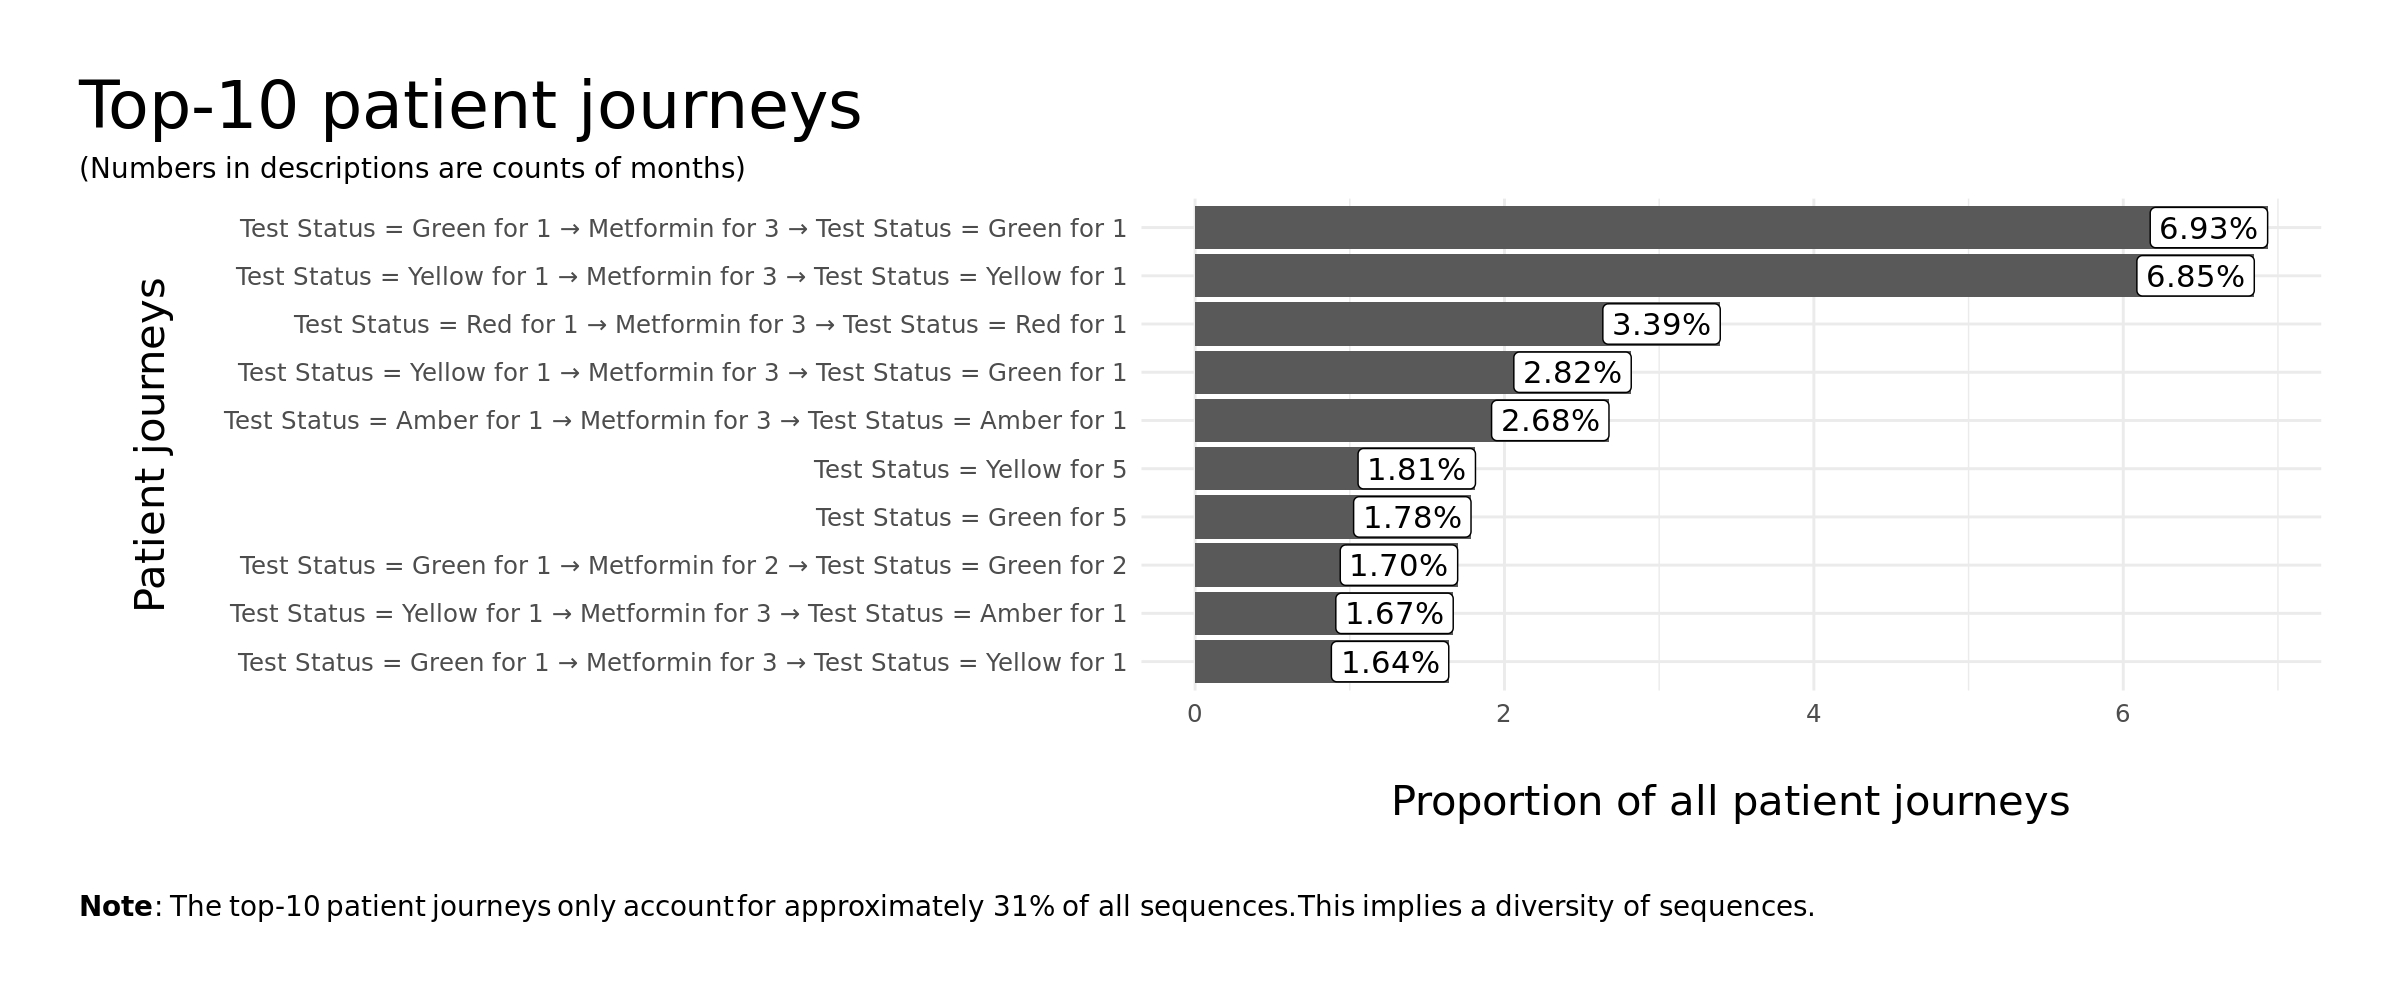

In [319]:
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

# Make plot data.
plot_data <-
    TraMineR::seqtab( sts_seqmine ) %>%
    attributes() %>%
    purrr::pluck( "freq" ) %>%
    tibble::rownames_to_column( "sequence" ) %>%
    dplyr::arrange( desc( Freq ) ) %>%
    dplyr::mutate( cum_sum_percent = cumsum( Percent ) ) %>%
    # Remove the leading "None/[0-9]"
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "None/[0-9]*-", "" ) )
        ) %>%
    # Replace the "-" that joins the events with an arrow.
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "-", " \u2192 " ) )
        ) %>%
    # Use words instead of symbols for the number of timesteps.
    dplyr::mutate_at(
        .vars = vars( sequence )
        ,.funs = funs( stringr::str_replace_all( ., "/", " for " ) )
        ) %>%
    suppressWarnings()


# Plot plot data.
plot_data %>%
    ggplot(
        aes(
            x = reorder( sequence, Freq )
            ,y = Percent )
        , stat = "identity"
    ) +
    geom_col() +
    geom_label(
            aes(
                label = Percent %>% `/`(100) %>% round(4) %>% scales::percent()
            )
            ,hjust = 1 ) +
    coord_flip() +
    labs(
        x = "Patient journeys"
        ,y = "Proportion of all patient journeys"
        ,title = "Top-10 patient journeys"
        ,subtitle = "(Numbers in descriptions are counts of months)"
        ,caption = paste0(
            "**Note**: The top-10 patient journeys only account for approximately "
            ,round( max( plot_data$cum_sum_percent ))
                   ,"% of all sequences. This implies a diversity of sequences."
                  )
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = "none"
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.x = element_text( margin = margin( t = 20, b = 20 ) )
        ,axis.title.y = element_text( margin = margin( r = 20, l = 20, t = 20 ) )
        )

Below are the month-by-month relative propotions of each event. In the previous iteration, the Clinical Review Board requested me to separate the test statuses from the prescriptions because they help to answer two distinct questions.

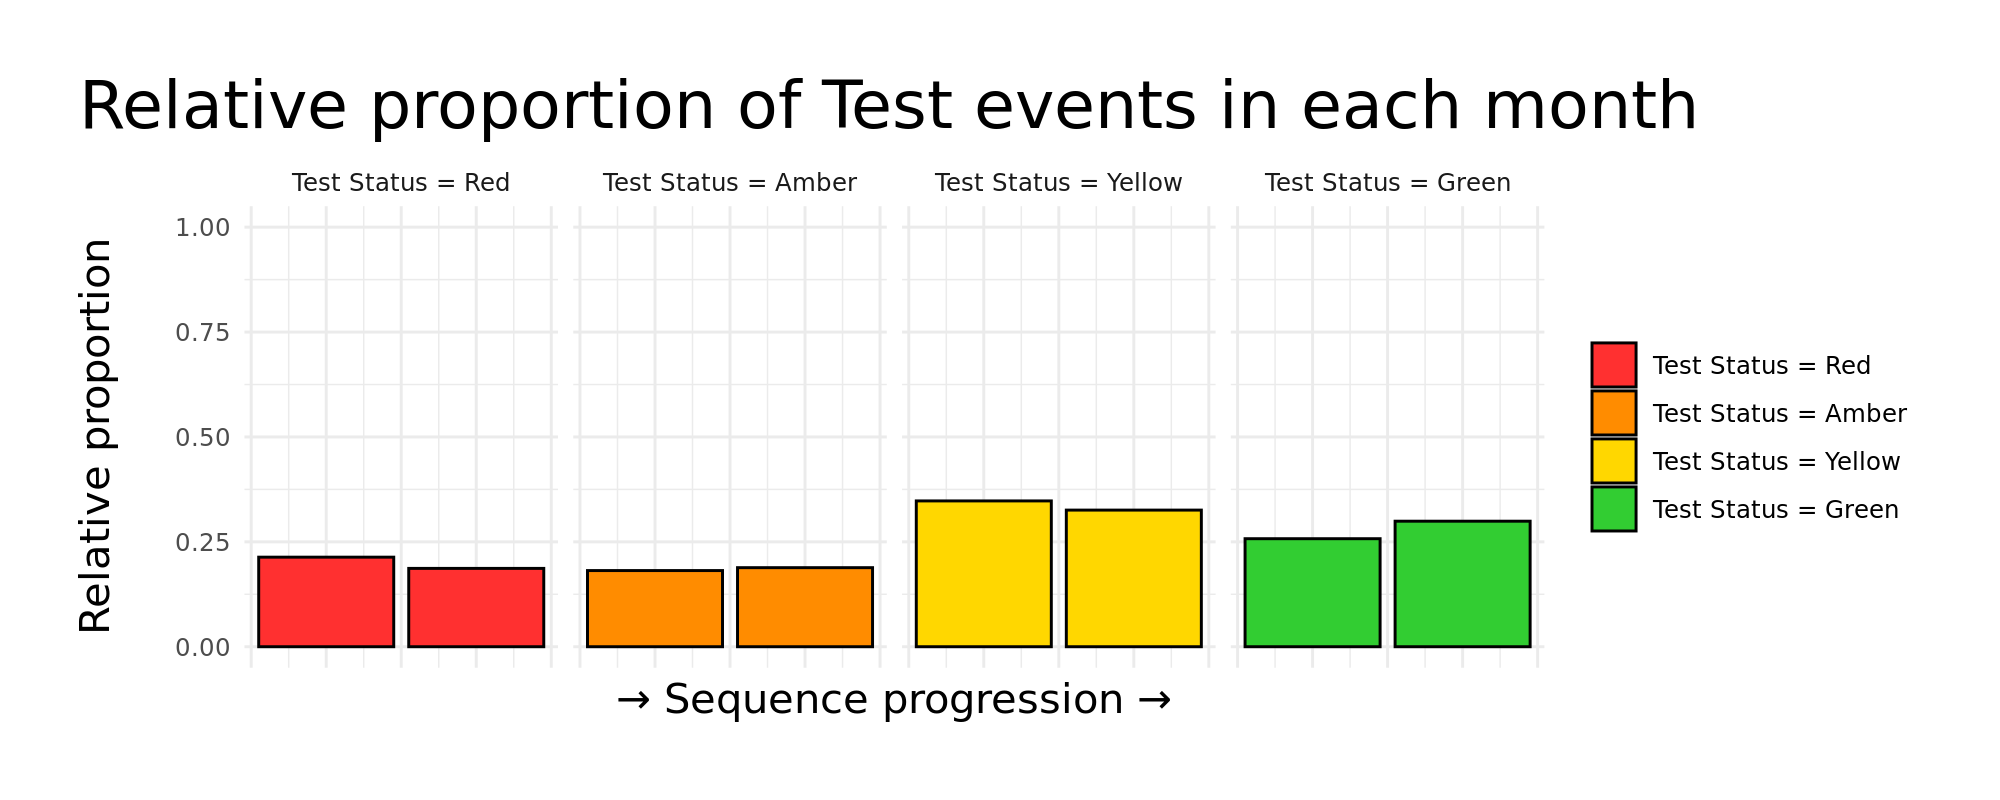

In [320]:
# Prepare plot data.
plot_data <-
    TraMineR::seqstatd( sts_seqmine_test_only ) %>%
    purrr::pluck( "Frequencies" ) %>%
    as.data.frame() %>%
    tibble::rownames_to_column( "event" ) %>%
    dplyr::filter( event != "None" ) %>%
    dplyr::select( -a1 ) %>%
    tidyr::pivot_longer(
        cols = !event
        ,names_to = "month"
        ,values_to = "proportion"
    ) %>%
    dplyr::mutate_at(
        .vars = vars( event )
        ,.funs = funs( factor (., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    dplyr::mutate_at(
        .vars = vars( month )
        ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
    ) %>%
    suppressWarnings()

# Plotting.
options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )
plot_relProp_TestStatuses <-
    plot_data %>%
    ggplot() +
    geom_bar(
        aes(
            x = month
            ,y = proportion
            ,fill = event
        )
        ,stat = "identity"
        ,colour = "black"
    ) +
    facet_wrap( ~ event, nrow = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull(1) ) +
    labs(
        x = "\u2192 Sequence progression \u2192"
        ,y = "Relative proportion"
        ,title = "Relative proportion of Test events in each month"
    ) +
    ylim(0, 1) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.x = element_blank()
        ,legend.title = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        )

plot_relProp_TestStatuses

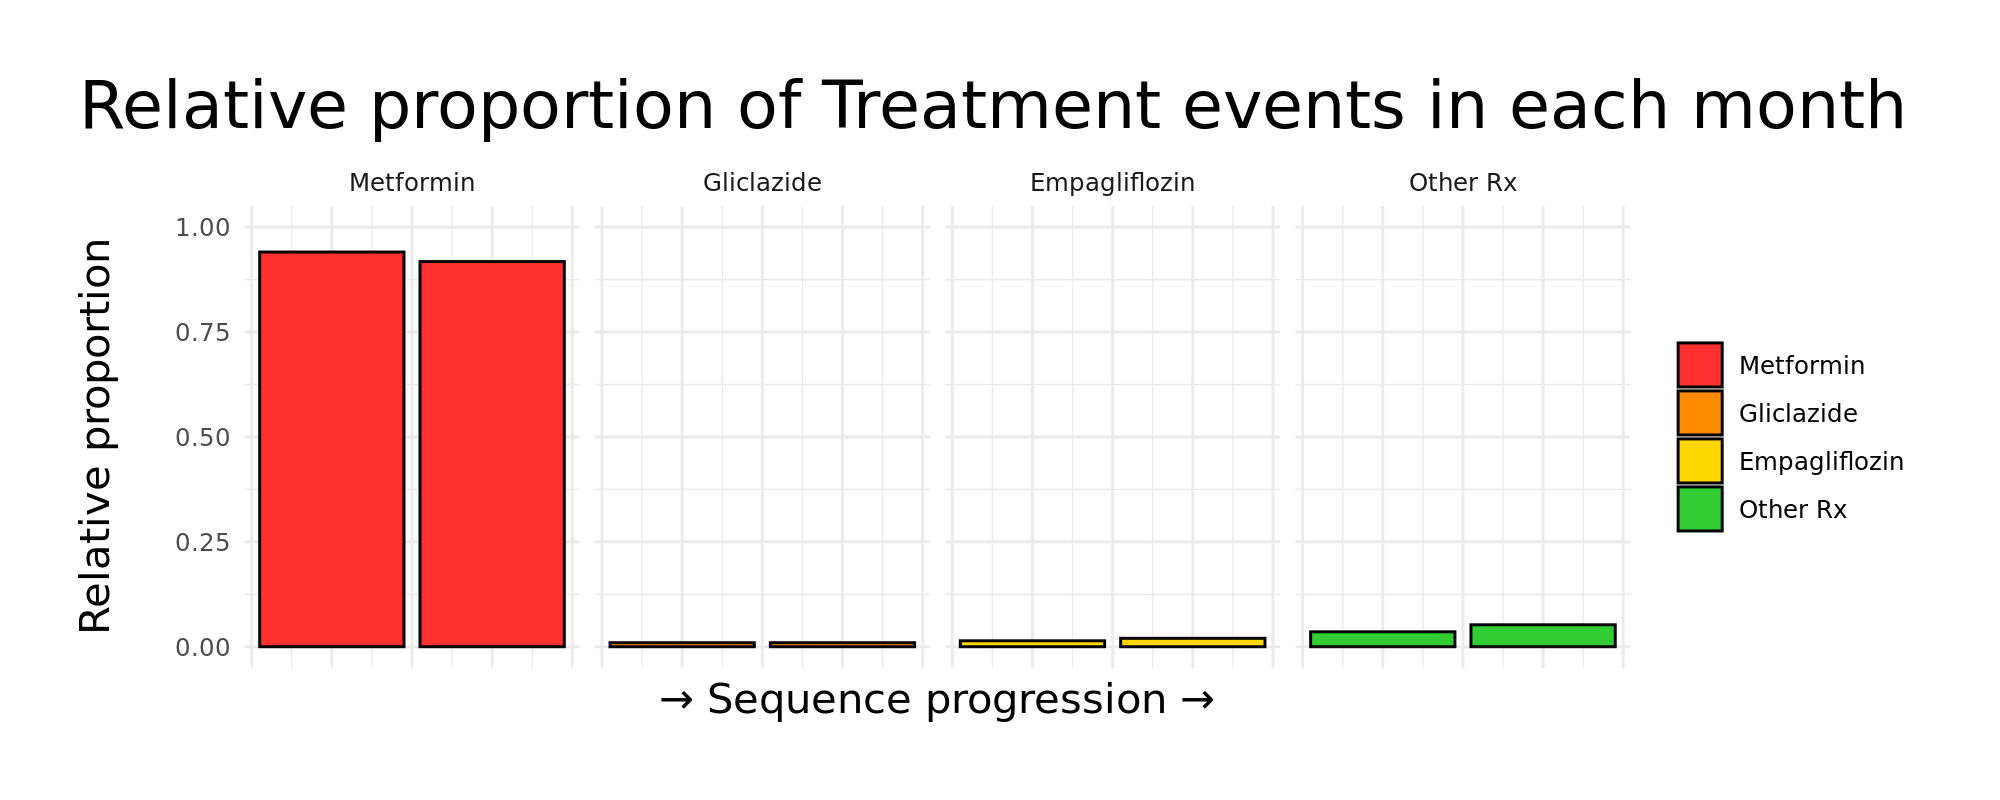

In [321]:
# Prepare plot data.
plot_data <-
    TraMineR::seqstatd( sts_seqmine_treatment_only ) %>%
    purrr::pluck( "Frequencies" ) %>%
    as.data.frame() %>%
    tibble::rownames_to_column( "event" ) %>%
    dplyr::filter( event != "None" ) %>%
    dplyr::select( -a1 ) %>%
    tidyr::pivot_longer(
        cols = !event
        ,names_to = "month"
        ,values_to = "proportion"
    ) %>%
    # Reorder the `event` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( event )
        ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    # Remove the "a" in the `month` variable values that were added by the TraMineR functions.
    dplyr::mutate_at(
        .vars = vars( month )
        ,.funs = funs( stringr::str_replace_all( ., "a", "" ) %>% as.integer() )
    ) %>%
    suppressWarnings()

# Plotting.
options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )

plot_relProp_Treatments <-
    plot_data %>%
    ggplot() +
    geom_bar(
        aes(
            x = month
            ,y = proportion
            ,fill = event
        )
        ,stat = "identity"
        ,colour = "black"
    ) +
    facet_wrap( ~ event, nrow = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull(1) ) +
    labs(
        x = "\u2192 Sequence progression \u2192"
        ,y = "Relative proportion"
        ,title = "Relative proportion of Treatment events in each month"
    ) +
    ylim(0, 1) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.x = element_blank()
        ,legend.title = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        )

plot_relProp_Treatments

Average duration that a patient spends in a "state" without changing.

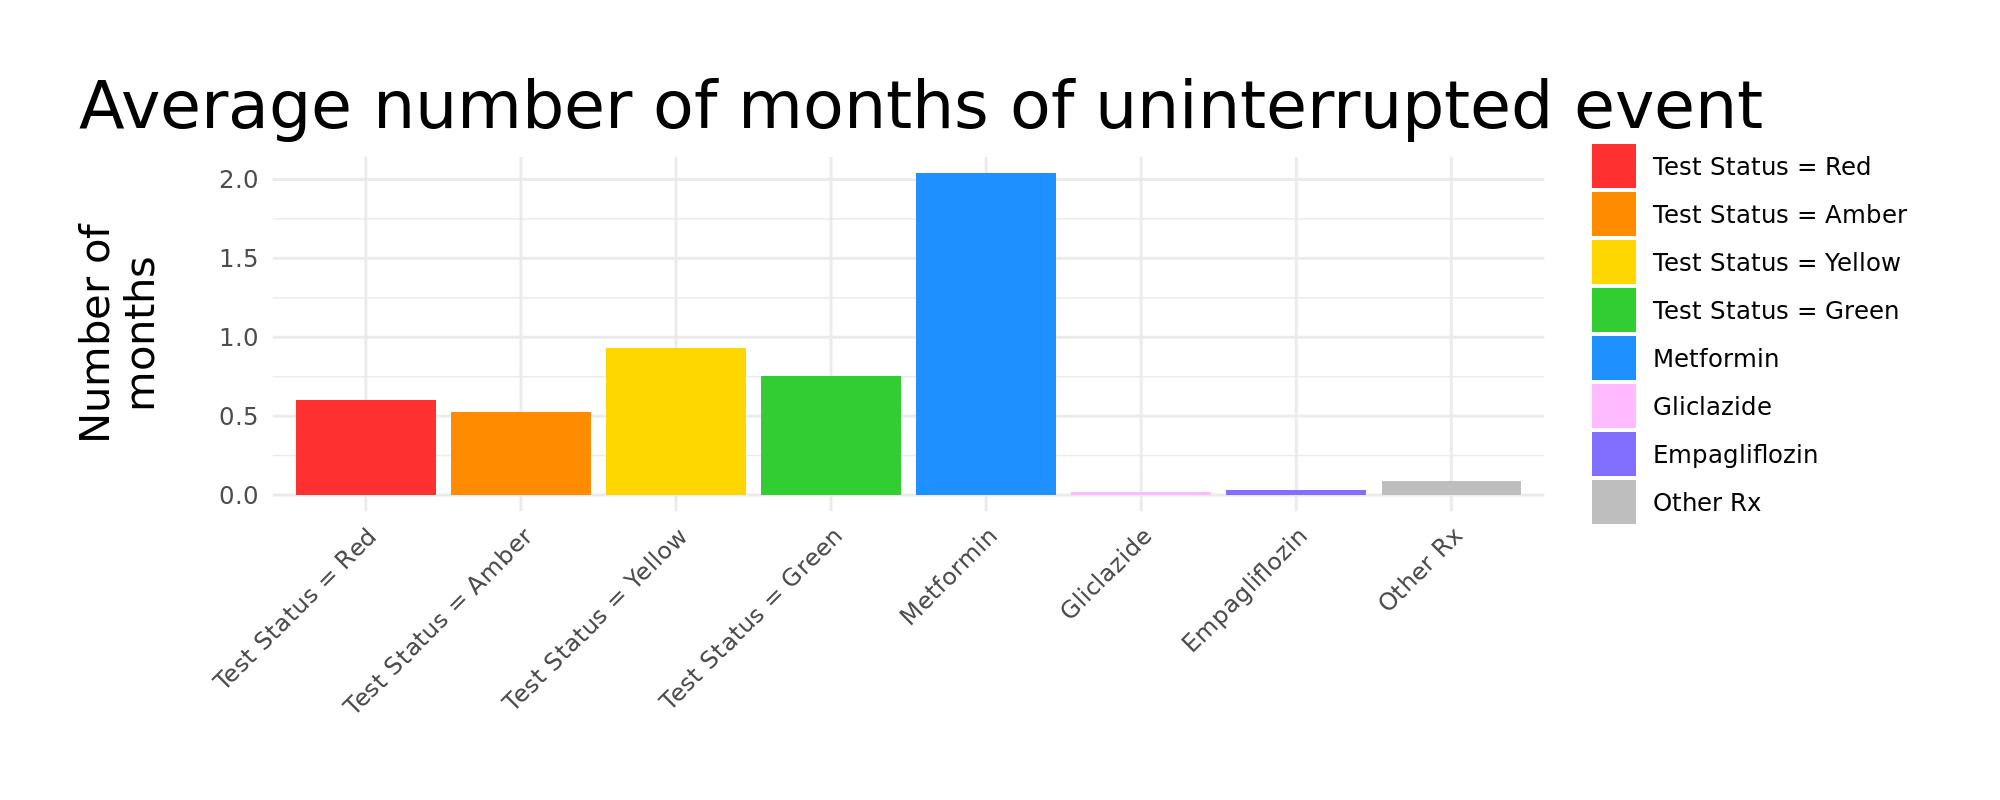

In [322]:
# Make plot data.
plotData <-
    TraMineR::seqmeant( sts_seqmine ) %>%
    as.data.frame() %>%
    tibble::rownames_to_column("event") %>%
    dplyr::left_join(
        df_event_factor
        ,by = join_by( event == event_fct_order)
    ) %>%
    dplyr::mutate_at(
        .vars = vars( event )
        ,.funs = funs( factor(., levels = df_event_factor %>% dplyr::select( event_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    dplyr::filter( event != "NA" ) %>%
    suppressWarnings()


# Plotting.
options( repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 200 )

plot_durationOfEvents <-
    plotData %>%
    ggplot() +
    geom_bar(
        aes(
            x = event
            ,y = Mean
            ,fill = event
        )
        ,stat = "identity" ) +
    scale_fill_manual( values = df_event_factor %>% dplyr::select( event_colours_order ) %>% dplyr::pull(1) ) +
    labs(
        title = "Average number of months of uninterrupted event"
        ) +
    ylab( "Number of\nmonths" ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.x = element_text( angle = 45, hjust = 1 )
        ,axis.title.x = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,legend.title = element_blank()
        )

plot_durationOfEvents

#### Burden of Treatment / Turbulence / Complexity of care

Calculate statistics that summarise and represent the complicatedness / complexity of patients' sequences, then plot as histograms.

_Component_

- The __Transitions Count__ statistic is the count of times a patient changes state during their sequence. It has an unbounded range and does not take the length of the sequence into account (i.e. low counts can indicate short sequences with little time to change state, or can indicate a long and stable sequence).
- The __$\mathbf{log_{2}}(Subsequence Count)$__ statistic is the  $log_{2}$ of the count of 'distinct successive states' during a patient's sequence. It has an unbounded range with a sequence-specific maximum reached when the sequence cycles between all its states. Low values can indicate either few changes or a small number of unique states observed in the sequence.
- The __Longitudinal Entropy__ statistic quantifies the entropy of the distribution of durations spent in each state observed in the sequence. It is a measure of diversity of states within a sequence. It's range is between 0 and 1 because each sequence's value is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet).

_Composite_

- The __Turbulence__ statistic is the $log_{2}$ of the product of the count of subsequences and a sequence-specific scaling parameter ([Elzinga et al. 2007](https://sci-hub.wf/10.1007/s10680-007-9133-7)). The sequence-specific scaling parameter is based on the variance of observed state durations (which we know to be inversely proportional to the notion of turbulent sequences). Larger values are associated with sequences that have many states, changes, and similar durations in each state. This statistic differs from the $\mathbf{log_{2}}(Subsequence Count)$ only by the sequence-specific scaling parameter within the $log_{2}$ operator.
- The __Complexity Index__ statistic is the geometric mean of a scaled count of transitions in a sequence and the sequence's scaled longitudinal entropy ([Gabadinho et al. 2010](https://www.researchgate.net/profile/Gilbert-Ritschard/publication/220786242_Indice_de_complexite_pour_le_tri_et_la_comparaison_de_sequences_categorielles/links/53edabdb0cf26b9b7dc5f259/Indice-de-complexite-pour-le-tri-et-la-comparaison-de-sequences-categorielles.pdf)). The count of transitions is scaled to the length of the sequence, and the longitundinal entropy is scaled to the theoretical maximum of $log_{a}$, where $a$ is the count of unique states across all sequences, even those not observed in the sequence (i.e. its alphabet). It's range is between 0 and 1.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”


TableGrob (1 x 1) "arrange": 1 grobs
  z     cells    name            grob
1 1 (1-1,1-1) arrange gtable[arrange]

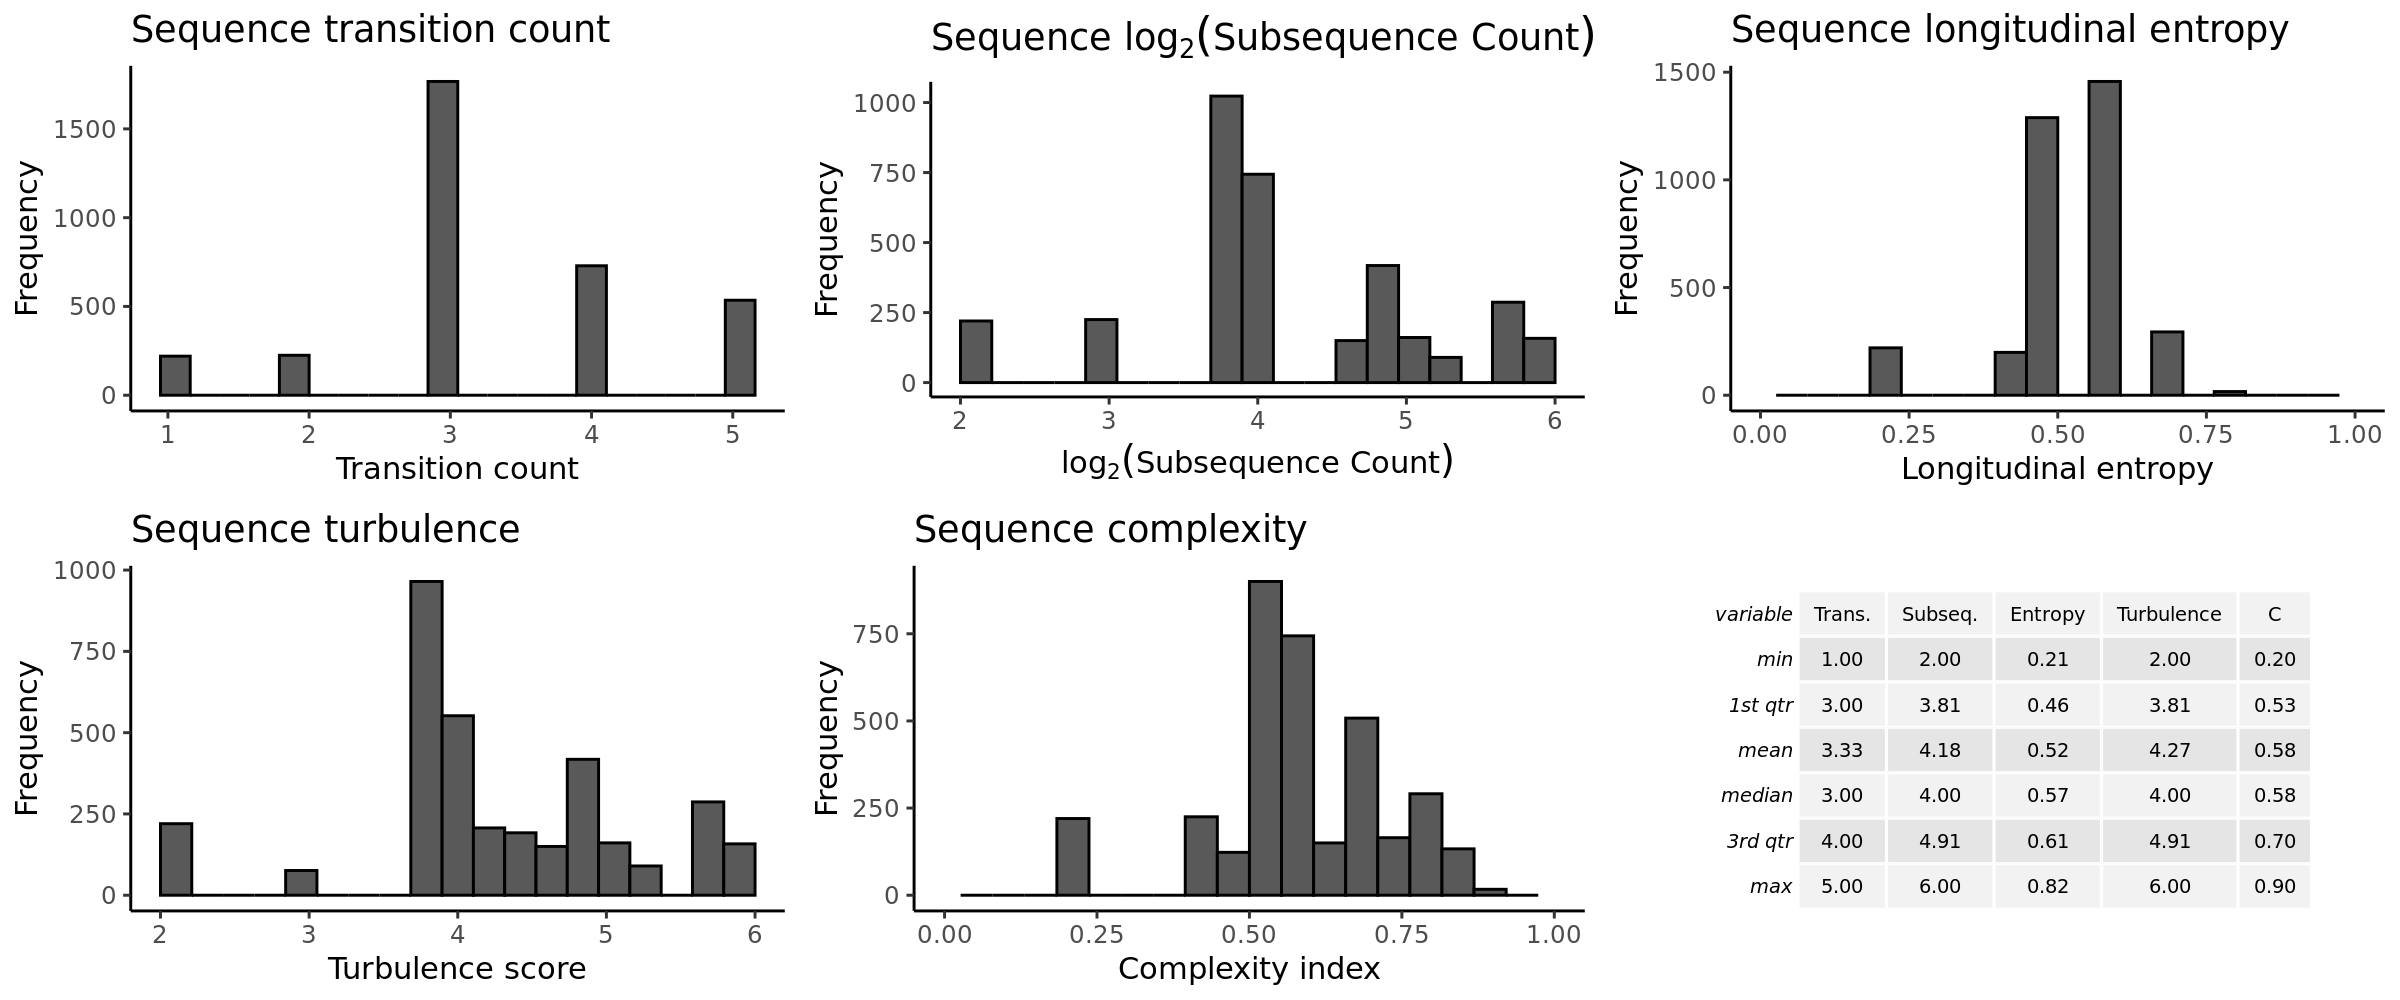

In [331]:
# Make plot data.
# ## Calculate statistics over all patient records.
seq_transitionCount <- TraMineR::seqtransn( sts_seqmine )
seq_subsequenceCount <- TraMineR::seqsubsn( sts_seqmine ) %>% log( base = 2 )
seq_longEntropy <- TraMineR::seqient( sts_seqmine )
seq_turbulence <- TraMineR::seqST( sts_seqmine )
seq_complexity <- TraMineR::seqici( sts_seqmine )

# Make plots.
# ## Plot histograms and summary statistics.
n_bins = 20
hist_trans <-
    seq_transitionCount %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Trans. ), bins = n_bins, colour = "black") +
    labs( title = "Sequence transition count", x = "Transition count", y = "Frequency" ) +
    theme_classic()
hist_subseq <-
    seq_subsequenceCount %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Subseq. ), bins = n_bins, colour = "black") +
    labs( title = base::bquote("Sequence "*log[2]("Subsequence Count")) , x = base::bquote(log[2]("Subsequence Count")), y = "Frequency" ) +
    theme_classic()
hist_entr <-
    seq_longEntropy %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Entropy ), bins = n_bins, colour = "black") +
    labs( title = "Sequence longitudinal entropy", x = "Longitudinal entropy", y = "Frequency" ) +
    xlim( 0, 1 ) +
    theme_classic()
hist_turb <-
    seq_turbulence %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( Turbulence ), bins = n_bins, colour = "black") +
    labs( title = "Sequence turbulence", x = "Turbulence score", y = "Frequency" ) +
    theme_classic()
hist_cidx <-
    seq_complexity %>%
    tibble::as_tibble() %>%
    ggplot() +
    geom_histogram( aes( C ), bins = n_bins, colour = "black") +
    labs( title = "Sequence complexity", x = "Complexity index", y = "Frequency" ) +
    xlim( 0, 1 ) +
    theme_classic()
# ## Create table of summary statistics.
plot_table <-
    seq_transitionCount %>%
    dplyr::bind_cols( seq_subsequenceCount, seq_longEntropy, seq_turbulence, seq_complexity ) %>%
    dplyr::summarise(
        across(
            everything()
            ,list(
                min = min
                ,`1st qtr` = ~quantile( ., 0.25 )
                ,mean = mean
                ,median = median
                ,`3rd qtr` = ~quantile( ., 0.75 )
                ,max = max
            )
        )
    ) %>%
    base::round(2) %>%
    pivot_longer(
        everything()
        ,names_sep = '_'
        ,names_to = c( 'variable', '.value' )
    ) %>%
    t() %>%
    gridExtra::tableGrob( theme = gridExtra::ttheme_default( base_size = 7) )

# ## Plot.
options( repr.plot.width = 12, repr.plot.height = 5, repr.plot.res = 200 )

plot_sequenceComplexity <-
    gridExtra::grid.arrange(
        gridExtra::arrangeGrob(
            hist_trans, hist_subseq, hist_entr, hist_turb, hist_cidx, plot_table
            ,ncol = 3
        )
    )

plot_sequenceComplexity

### Sankey plots

I've been trying to use `ggsankey`, reading from these resources:
- https://github.com/davidsjoberg/ggsankey
- https://r-charts.com/flow/sankey-diagram-ggplot2/

<b>Note: The Sankey plots show data that are in <u>ST</u>ate <u>S</u>equence format. This means that:</b>
1. <b>the number of sequence steps is decided by the maximum number of sequence steps observed across the dataset, _and_</b>
2. <b>a state remains unchanged in the sequence by default, rather than records being lost to follow-up.</b>
<br>
<br>
<br>
<br>

First, I show a basic Sankey plot showing patients' test results at each testing event and visualise the proportion of patients that switch between test statuses.

#### Test Statuses

In [324]:
# Define list of events to focus on.
events_selection <-
    df_event_factor %>%
    dplyr::select( event_fct_order ) %>%
    dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>%
    droplevels() %>%
    dplyr::pull()

# Create the data transition matrix.
stm_Tests <-
    events_selection %>%
    rep(.,  times = length(.) ) %>%
    matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
    `colnames<-`( events_selection ) %>%
    `rownames<-`( events_selection ) %>%
    rbind(.[1,], .)
rownames( stm_Tests )[1] <- 'None'

# Convert the time series dataframe to a state sequence object.
sts_seqmine_Tests <-
    TraMineRextras::TSE_to_STS(
        df_seq %>% dplyr::filter( stringr::str_detect( event_value, pattern = "Test" ) )
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "event_value"
        ,stm = stm_Tests
        ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( labels = c('None', events_selection ) ) %>%
    suppressMessages()

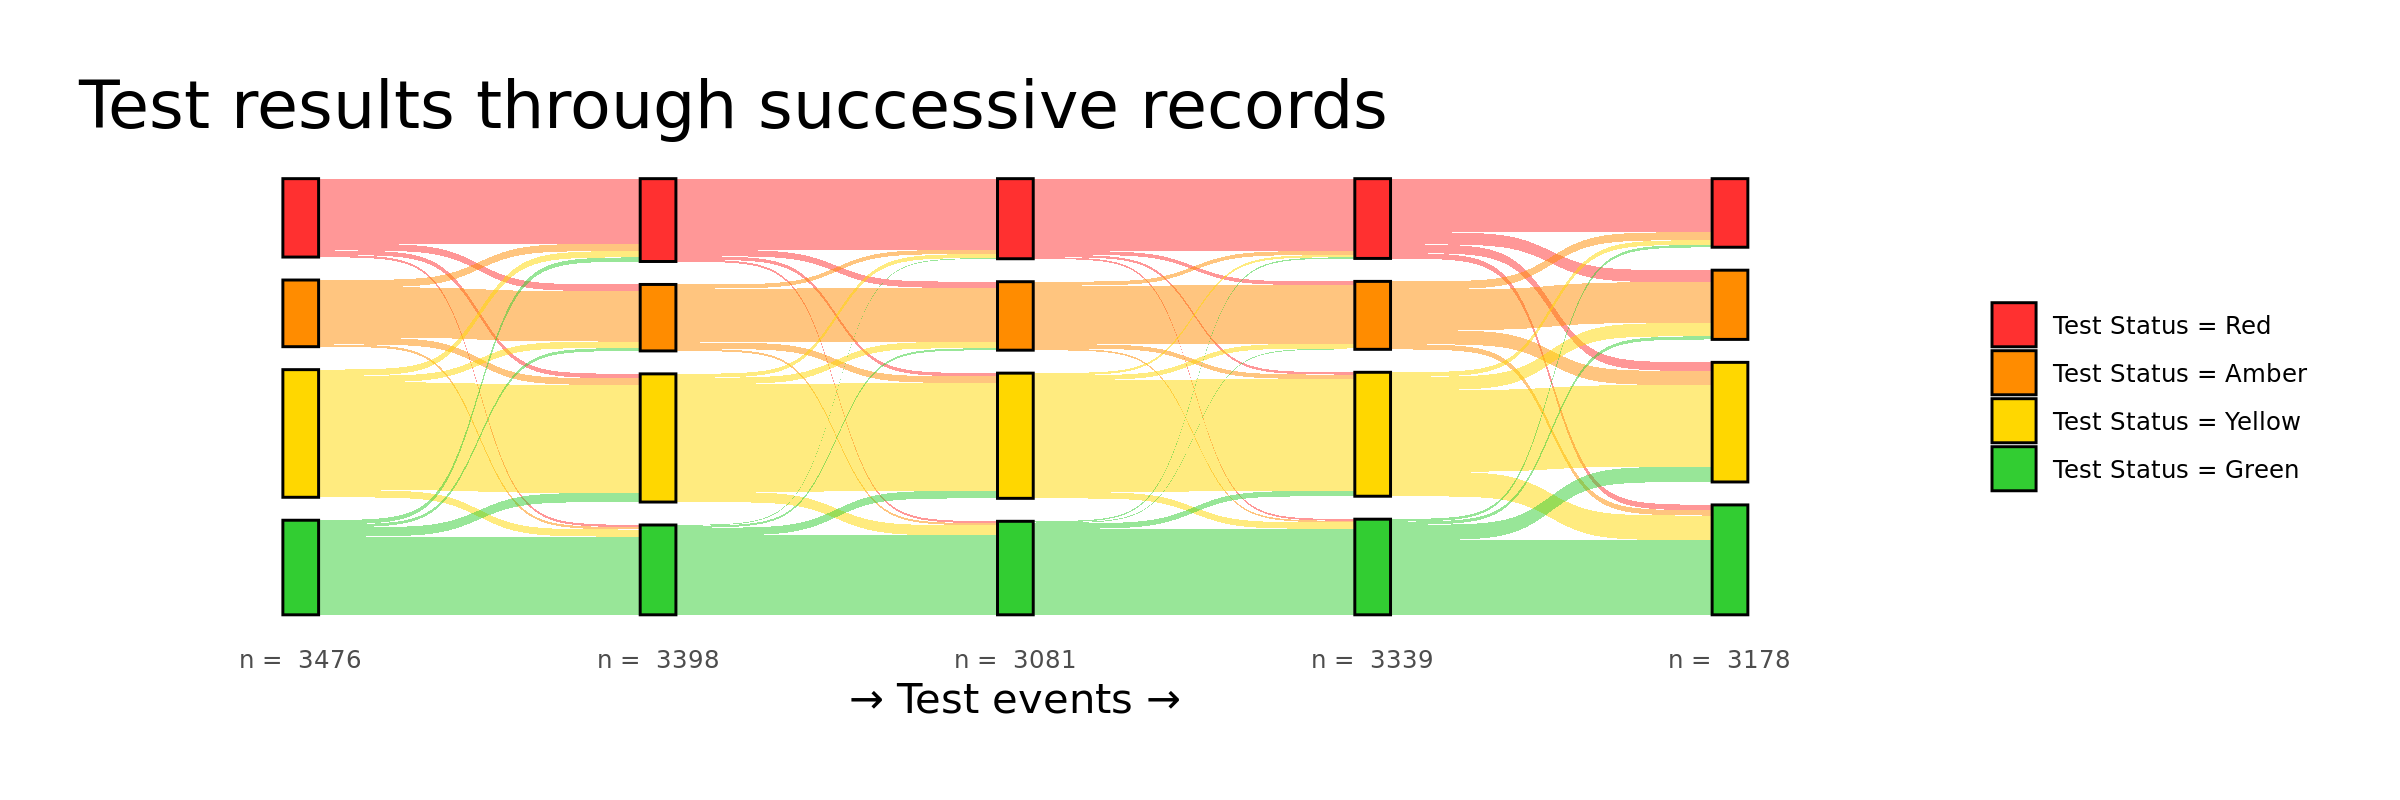

In [325]:
# Make plot data.
plotData <-
    sts_seqmine_Tests %>%
    dplyr::select( - a1 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_fct_order ) %>% droplevels() %>% dplyr::pull() ) )
    ) %>%
    suppressWarnings()

# PLot.
options( repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 200 )

plot_testStatus_Sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    geom_sankey( flow.alpha = 0.5, node.color = 1) +
    scale_fill_manual( values = df_event_factor %>% dplyr::filter( stringr::str_detect( event_fct_order, pattern = "Test" ) ) %>% dplyr::select( event_colours_order ) %>% droplevels() %>% dplyr::pull() ) +
    scale_x_discrete( labels = n_person_at_each_stage %>% dplyr::pull() ) +
    guides( fill = guide_legend( title = "Test Status") ) +
    labs(
        title = "Test results through successive records"
        ,x = "\u2192 Test events \u2192"
    ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.title = element_blank()
        ,axis.text.y = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_testStatus_Sankey

Some initial observations from the Test Statuses Sankey diagram:
1. __The overall count of patient records in each level of Test Status is approximately stable.__
    - Evidenced by little variation in the height of the vertical bars, over time.
2. __Patient records indicating a particular Test Status level predominantly stay in that Test Status level.__
    - Evidenced by the largest ribbon joining subsequent vertical bars almost exclusively comes from the the same Test Status level.
3. __The Test Status levels that change between every test event rarely change by more than one level.__
    - Evidenced by many ribbons linking vertically-adjacent bars at subsequent test points.

#### R.A.M.E. strata

In the next plot, the Sankey plot visualises the proportions of patients moving between strata of the R.A.M.E. stratification.

R.A.M.E. stratification is something CB proposed. It has four strata infomed by two components: the testing interval since the previous test {'Expected', 'Shorter-than-expected'}, and the change in prescriptions compared with the previous testing interval {'No observed change', 'Observed change'}. The stratification gets its name from the four strata: (0,0)-Run; (0,1)-Adjust; (1,0)-Monitor; (1,1)-Escalate.

The first task is to create a new state-sequence object that tracks R.A.M.E. strata.

In [326]:
# Define list of events to focus on.
events_selection <-
    df_RAME_factor %>%
    dplyr::select( RAME_fct_order ) %>%
    droplevels() %>%
    dplyr::pull()

# Create the data transition matrix.
stm_RAME <-
    events_selection %>%
    rep(.,  times = length(.) ) %>%
    matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
    `colnames<-`( events_selection ) %>%
    `rownames<-`( events_selection ) %>%
    rbind(.[1,], .)
rownames( stm_RAME )[1] <- 'None'

# Convert the time series dataframe to a state sequence object.
sts_seqmine_RAME <-
    TraMineRextras::TSE_to_STS(
        df_seq
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "RAME"
        ,stm = stm_RAME
        ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( labels = c('None', events_selection ) ) %>%
    suppressMessages()

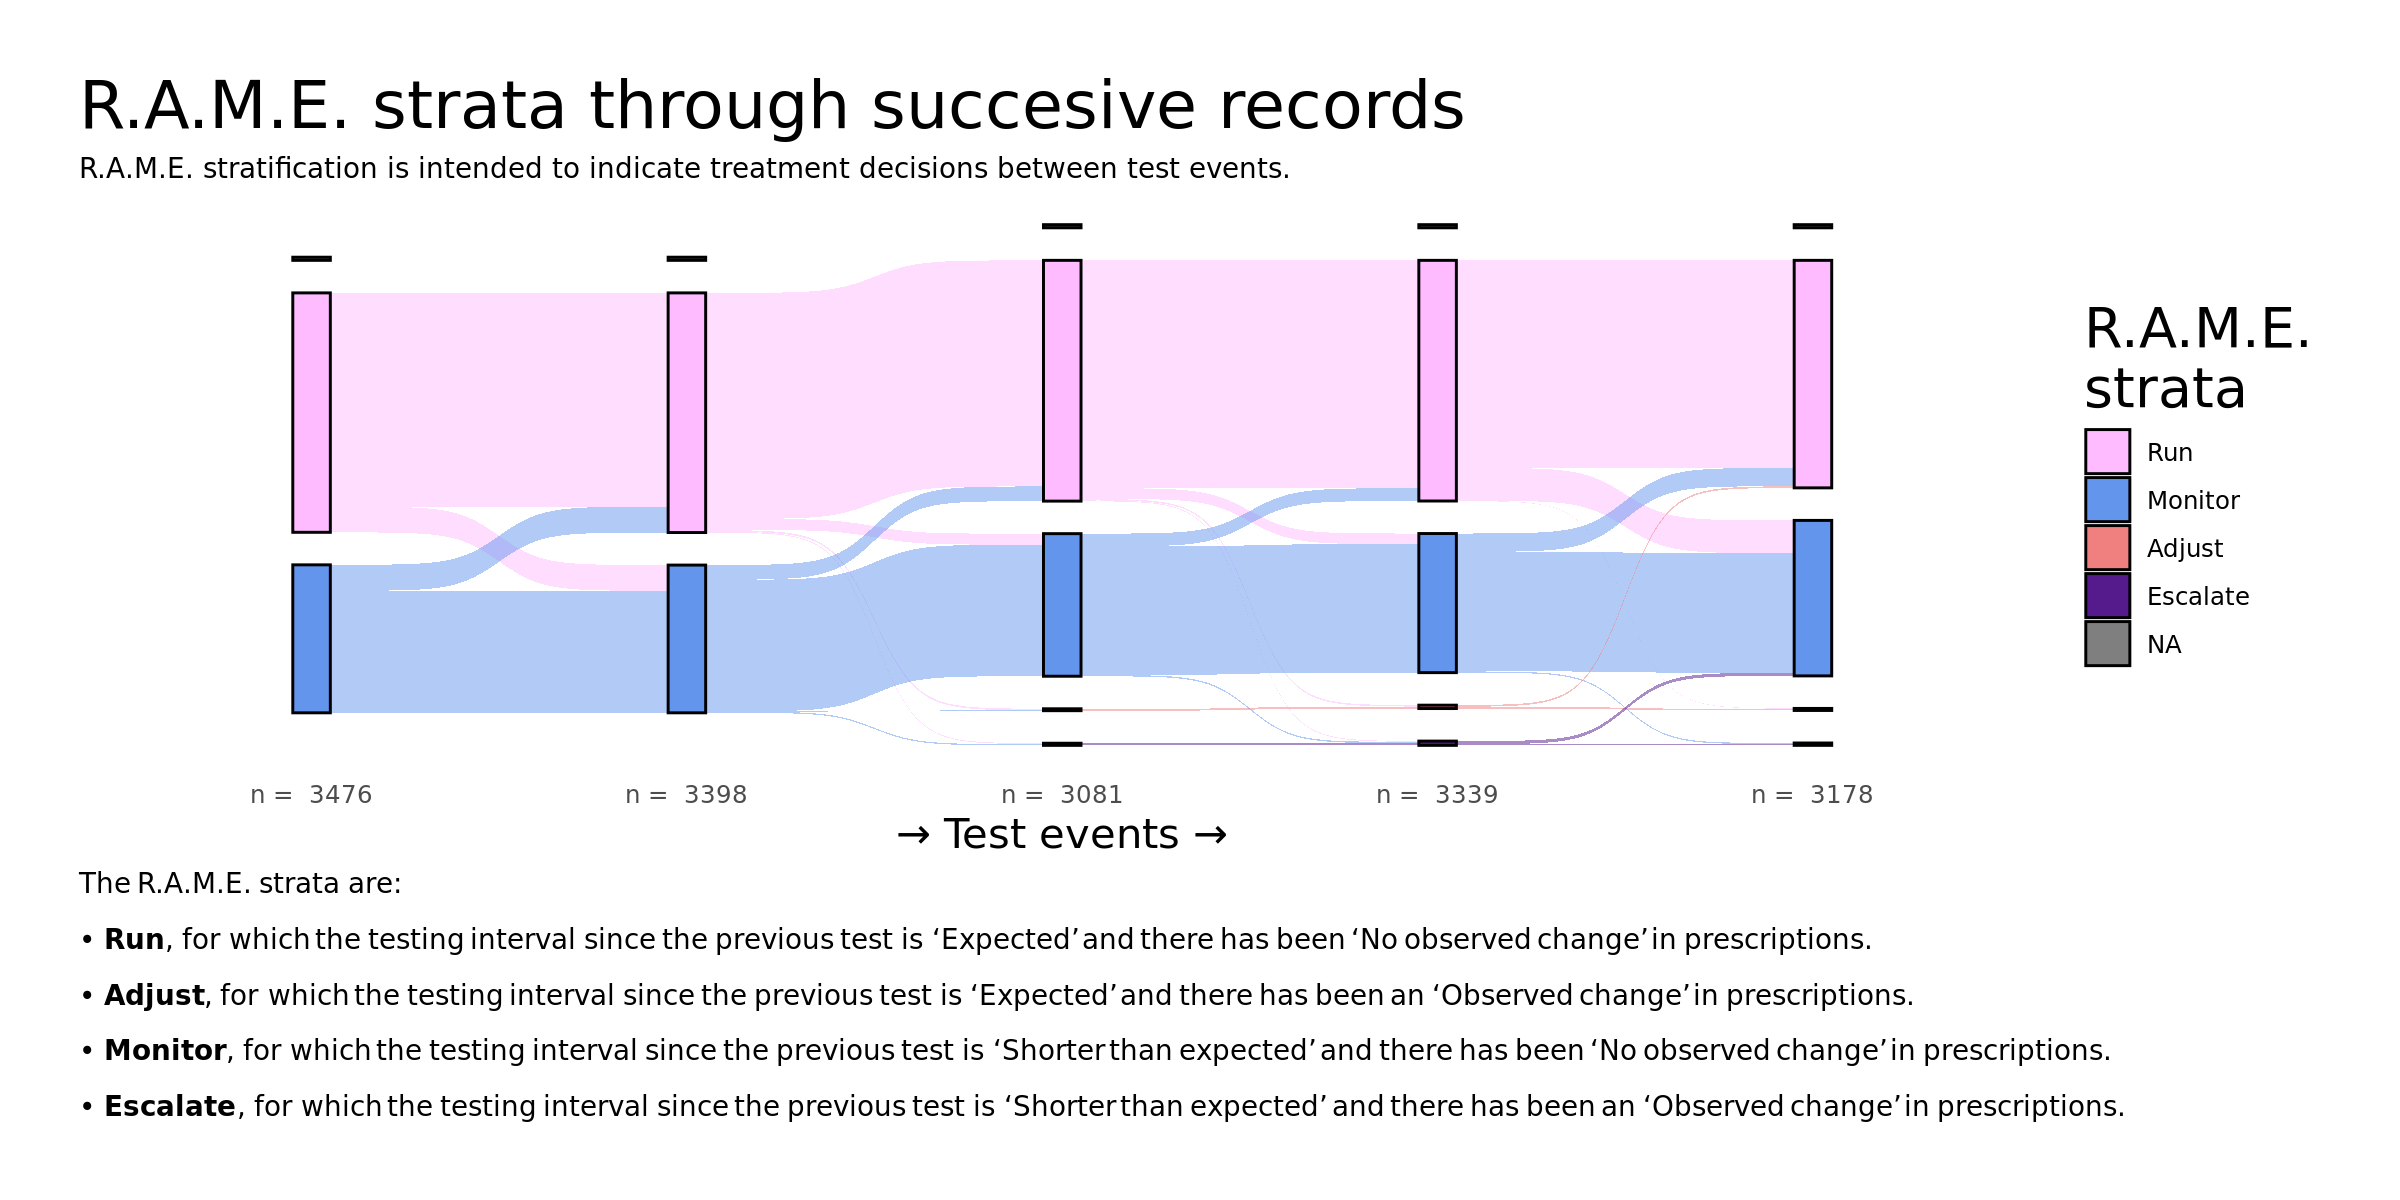

In [327]:
# Make plot data.
plotData <-
    sts_seqmine_RAME %>%
    dplyr::select( - a1 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_seq %>% dplyr::distinct( RAME ) %>% dplyr::pull(1) ) )
    ) %>%
    suppressWarnings()

# Plot.
options( repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 200 )

plot_RAME_Sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    geom_sankey( flow.alpha = 0.5, node.color = 1) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_RAME_factor %>% dplyr::select( RAME_colours_order ) %>% dplyr::pull() ) +
    scale_x_discrete( labels = n_person_at_each_stage %>% dplyr::pull() ) +
    labs(
        title = "R.A.M.E. strata through succesive records"
        ,subtitle = "R.A.M.E. stratification is intended to indicate treatment decisions between test events."
        ,x = "\u2192 Test events \u2192"
        ,caption = paste0(
            "The R.A.M.E. strata are:<br><br>"
            ,"\u2022 **Run**, for which the testing interval since the previous test is 'Expected' and there has been 'No observed change' in prescriptions.<br><br>"
            ,"\u2022 **Adjust**, for which the testing interval since the previous test is 'Expected' and there has been an 'Observed change' in prescriptions.<br><br>"
            ,"\u2022 **Monitor**, for which the testing interval since the previous test is 'Shorter than expected' and there has been 'No observed change' in prescriptions.<br><br>"
            ,"\u2022 **Escalate**, for which the testing interval since the previous test is 'Shorter than expected' and there has been an 'Observed change' in prescriptions."
            )
    ) +
    guides( fill = guide_legend( title = "R.A.M.E.\nstrata")) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 10 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,axis.text.y = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

plot_RAME_Sankey

Some initial observations from the R.A.M.E. Sankey diagram:
1. __Most patient records indicate a 'Run' strategy.__
    - Evidenced by the green 'Run' vertical bars being the largest.
2. __Patient records are overwhelmingly likely to maintain their previous R.A.M.E. category.__
    - Evidenced by he largest ribbon joining subsequent vertical bars almost exclusively comes from the the same R.A.M.E. strategy.
3. __Very few patient records indicate the undesirable categories of 'Escalate' or 'Adjust'.__
    - Evidenced by the barely visible vertical bars that represent the counts of patients in the 'Escalate' and 'Adjust' categories.

#### T-and-P strata

In the next plot, the Sankey plot visualises the proportions of patients moving between strata of the T-and-P stratification.

The T-and-P stratification is something CB proposed. It has 17 strata derived from combining the test status, T, {Test status = Red, Test status = Amber, Test status = Yellow, Test status = Green} with a variable indicating the count of unique medications prescribed in previous inter-test intervals, P, {0, 1, 2, 3}, i.e. poly-pharmacy. One additional strata is designated for where errors arise in the data.

The first task is to create a new state-sequence object that tracks T-and-P strata.

In [328]:
# Define list of events to focus on.
events_selection <-
    df_TandP_factor %>%
    dplyr::select( TandP_fct_order ) %>%
    droplevels() %>%
    dplyr::pull()

# Create the data transition matrix.
stm_TandP <-
    events_selection %>%
    rep(.,  times = length(.) ) %>%
    matrix( nrow = sqrt( length(.) ), byrow = TRUE ) %>%
    `colnames<-`( events_selection ) %>%
    `rownames<-`( events_selection ) %>%
    rbind(.[1,], .)
rownames( stm_TandP )[1] <- 'None'

# Convert the time series dataframe to a state sequence object.
sts_seqmine_TandP <-
    TraMineRextras::TSE_to_STS(
        df_seq
        ,id = "person_id"
        ,timestamp = "rn"
        ,event = "TandP"
        ,stm = stm_TandP
        ,tmax = df_seq %>% dplyr::select( rn ) %>% dplyr::ungroup() %>% max()
    ) %>%
    TraMineR::seqdef( ) %>%
    suppressMessages()

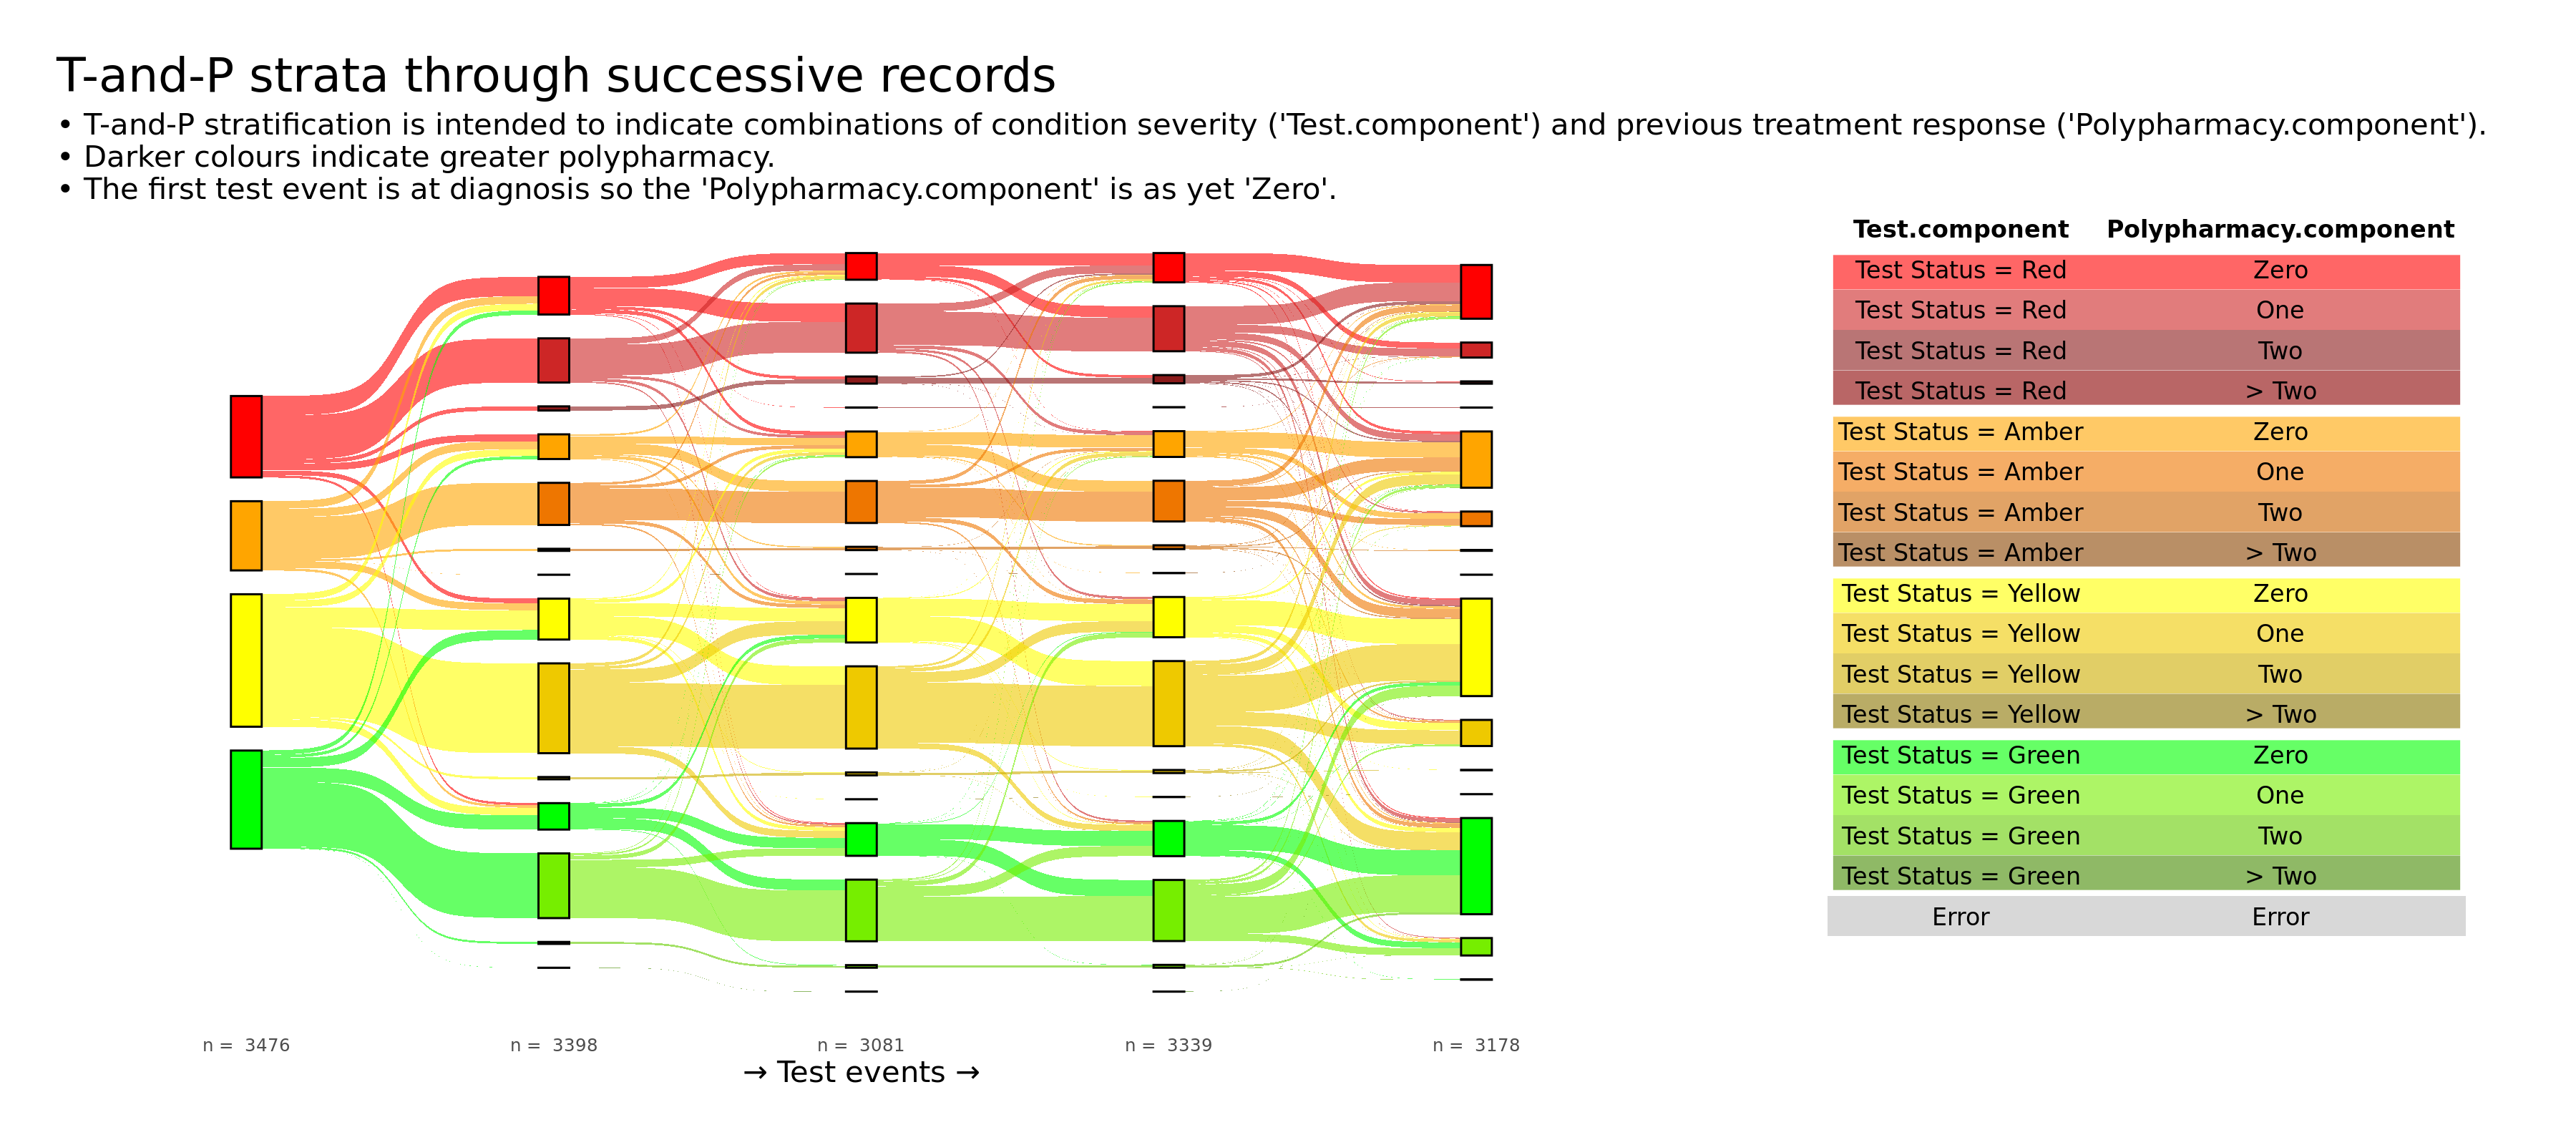

In [329]:
# Make plot data.
plotData <-
    sts_seqmine_TandP %>%
    # Remove the default start node.
    dplyr::select( - a1 ) %>%
    ggsankey::make_long( colnames( . ) ) %>%
    # Reorder the `node` variable values to make their colours.
    dplyr::mutate_at(
        .vars = vars( node, next_node )
        ,.funs = funs( factor( ., levels = df_TandP_factor %>% dplyr::select( TandP_fct_order ) %>% dplyr::pull(1) ) )
    ) %>%
    suppressWarnings()

# Make plot graphic.
plot_sankey <-
    plotData %>%
    ggplot(
        aes(
            x = x
            ,next_x = next_x
            ,node = node %>% factor( ., levels = rev( levels( . ) ) )            # I reverse the order because ggsankey orders 
            ,next_node = next_node %>% factor( ., levels = rev( levels( . ) ) )  # bottom to top while the legend is ordered
            ,fill = node                                                         # top to bottom.
        )
    ) +
    geom_sankey(
        flow.alpha = 0.6, # flow.alpha is deciding the transparency of the ribbon colour.
        node.color = 1) +
    labs(
        title = "T-and-P strata through successive records"
        ,subtitle =
            paste0(
                "\u2022 T-and-P stratification is intended to indicate combinations of condition severity (\'Test.component"
                ,"\') and previous treatment response (\'Polypharmacy.component\').\n"
                ,"\u2022 Darker colours indicate greater polypharmacy.\n"
                ,"\u2022 The first test event is at diagnosis so the \'Polypharmacy.component\' is as yet \'Zero\'."
            )
        ,x = "\u2192 Test events \u2192"
    ) +
    # Colour the strata using a traffic-light palette.
    scale_fill_manual( values = df_TandP_factor %>% dplyr::select( TandP_colours_order ) %>% dplyr::pull(1) %>% scales::alpha(1) ) + # scales::alpha() is deciding the transparency of the bar colours.
    scale_x_discrete( labels = n_person_at_each_stage %>% dplyr::pull() ) +
    theme_minimal() +
    theme(
        title = element_text( size = 20 )
        ,plot.subtitle = element_text( size = 15 )
        ,axis.title = element_text( size = 15 )
        ,plot.caption = ggtext::element_markdown( size = 10, hjust = 0 )
        ,plot.caption.position = 'plot'
        ,plot.title.position = 'plot'
        ,legend.position = 'none'
        ,axis.text.y = element_blank()
        ,plot.margin = unit( c(1, 1, 1, 1), "cm")
        ,axis.title.y = element_text( margin = margin( r = 20 ) )
        ,panel.grid.major = element_blank()
        ,panel.grid.minor = element_blank()
        )

# Make table explaining the strata.
plot_table <-
    TandP_display_table %>%
    dplyr::select( - Value ) %>%
    # Basic table layout.
    gridExtra::tableGrob(
        rows = NULL
        ,theme = 
        ttheme_minimal(
            core = list(
                bg_params = list( fill = df_TandP_factor %>% dplyr::select( TandP_colours_order ) %>% dplyr::pull() %>% scales::alpha(0.6), col = NA ) # scales::alpha() is deciding the transparency of the table colours.
            )
        )
    ) %>%
    # Add sub-table borders to set the groups of colours apart.
    gtable::gtable_add_grob(
        grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
        ,t = 2, b = 5, l = 1, r = 2
    ) %>%
    gtable::gtable_add_grob(
        grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
        ,t = 6, b = 9, l = 1, r = 2
    ) %>%
    gtable::gtable_add_grob(
        grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
        ,t = 10, b = 13, l = 1, r = 2
    ) %>%
    gtable::gtable_add_grob(
        grobs = grid::rectGrob( gp = gpar( fill = NA, col = "white", lwd = 8 ) )
        ,t = 14, b = 17, l = 1, r = 2
    )
            
# Plot.
options( repr.plot.width = 18, repr.plot.height = 8, repr.plot.res = 200 )

plot_TandP_Sankey <-
    cowplot::plot_grid(
        plot_sankey, plot_table
        ,nrow = 1
        ,rel_widths = c( 2/3, 1/3 )
    )

plot_TandP_Sankey

Some initial observations from the T-and-P Sankey diagram:
1. __'Test Status = Green' records always have low values for the polypharmacy component.__
    - Evidenced by absence of "> Two" value and disappearance of "Two" value half way through the period.
2. __Patient records predominantly show either no prescriptions or many prescriptions.__
    - Evidenced by very small vertical bars for he "One" and "Two" values for the polypharmacy component.
3. __Polypharmacy is more likely as subsequent testing continues.__
    - Evidenced by larger vertical bars with darker colours on the right of the plot, with simultaneous dwindling of lighter-colour bars, within each Test Status.

### 2.4.2 Build simulation models, if applicable
Not applicable for this iteration.

### 2.4.3 Design and test model evaluation rig
Not applicable for this iteration.

### 2.4.4 Set up and/or update the evidence template
Not applicable for this iteration.

## Stage 5: Evaluation
This tasks for this stage are:
1. Meet with Clinical Review Board to assess validity.
2. Set requirements for next interation of stages 1-5.

### 2.5.1. Meet with Clinical Review Board to assess validity
Notes from meeting of the Clinical Review Board on Friday 15th March:
- Of the complexity statistics, the count of transitions is the most intuitive and the complexity index is the most considerate.
- The Sankey plots are insightful, suggesting, at least, high-level inertia/stability of cohort size. But it is not clear from the Sankey plots of the records the volatility of individual patients with respect to the movement between strata.
- The distribution of complexity indices might help to clarify the extent of individual-patient volatility with respect to the movement between strata. The plot is unimodel and approximately symmetrical around the half-way point in the 0-1 range. This suggests that most patient records are moderately volatile but a few patient records are highliy volatile.

### 2.5.2 Set requirements for next interation of stages 1-5.
Requirements for the next iteration are:
1. Change the colours of the R.A.M.E. Sankey plot so as not to confuse them with the RAYG palette of the test statuses.
2. Reorder the R.A.M.E. and T-and-P plots so that the red flows are on top (i.e. RAYG from top to bottom to match the tabular legend).
3. Limit our sequence-complexity plots to the count of transitions and the complexity index.
4. Encode a preliminary measure of multimorbidity.
5. Stratify the complexity indices by our preliminary measure of multimorbidity.
6. Make a pin-and-string versions of the Sankey diagrams wherein each axis' node is a point (i.e. the pins) and the flows represent individual patients (i.e. the strings). Preferably, be able to randomly select x-many patients for plotting.
7. Add to all complexity-statistic visualiation a statement describing the state space of the sequence.
8. Rename "prescription" and "treatment" as "intervention", throughout.

# Appendix

### Alluvial plot

I've been desparately and unsucessfully trying to use `ggalluvial`, reading from these resources:
- https://medium.com/@arnavsaxena96/all-about-alluvial-diagrams-21da1505520b
- https://rdocumentation.org/packages/ggalluvial/versions/0.12.5
- https://jtr13.github.io/cc21fall2/ggalluvial-cheatsheet.html

None of the the `fill` or `colour` arguments will work, and I still don't understand the arguments in the main functions. Fail.

In [330]:
seq_selection <- df_seq %>% dplyr::select( person_id, RAME, idx_test_interval, test_status_rollover ) %>% distinct() %>% dplyr::mutate_at( .vars = vars( idx_test_interval, RAME ),.funs = funs(as.factor) ) %>% suppressWarnings()
seq_selection <-
    seq_selection %>%
    dplyr::left_join(
        dplyr::summarise( ., Freq = n(), .by = c(RAME, idx_test_interval) )
        ,by = join_by( RAME, idx_test_interval)
    ) %>%
    dplyr::select( - person_id ) %>%
    dplyr::distinct() %>%
    dplyr::arrange( idx_test_interval, RAME ) %>%
    dplyr::mutate(
        alluvium = rep( 1:16, length.out = nrow(.) )
        )
seq_selection -> plotData
#plotData %>% select(RAME, Freq, alluvium, idx_test_interval, test_status_rollover) %>% head()

# I want to get to a point where I can run the following code.
plotData %>%
ggplot(
       aes(
           x = idx_test_interval
           ,stratum = test_status_rollover
           ,alluvium = alluvium
           ,y = Freq
           ,label = test_status_rollover
       )
) +
#geom_flow() +
geom_alluvium() +
geom_stratum() +
geom_text( stat = "stratum" )

ERROR: Error in geom_alluvium(): could not find function "geom_alluvium"


### Weird data

Some of the data are anomolous.
Weird data:

1.
*person_id == 215643 has metformin a decade before a diagnosis...?
- qry_log_prescription %>% dplyr::filter( person_id %in% c(215643 ) ) 


2.
person_id %in% c( 30766, 27021, 285981, 306027) are given metformin even though their "diagnosis" test is 'Green'. In other words, the HbA1c test immediately preceding the first record of metformin is within a normal range.


In [21]:
pid = 215643
ppl_with_T2DM_diagnoses %>% dplyr::filter( person_id %in% pid )
qry_log_prescription %>% dplyr::filter( person_id %in% pid )
#print("\n\nPrescriptions\n")
#qry_log_prescription_longFormat %>% dplyr::filter( person_id %in% pid ) %>% dplyr::arrange( start_dttm )
#qry_log_test_longFormat %>% dplyr::filter( person_id %in% pid ) %>% dplyr::arrange( start_dttm )
df_log_PandT_longFormat %>% dplyr::filter( person_id %in% pid ) %>% dplyr::arrange( start_dttm )



# Source:   SQL [1 x 2]
# Database: BigQueryConnection
  person_id date_diagnosis     
      <int> <dttm>             
1    215643 2019-01-24 14:30:44

# Source:   SQL [1 x 2]
# Database: BigQueryConnection
  person_id date_first_prescription
      <int> <dttm>                 
1    215643 2009-07-22 16:32:27    

person_id,event_name,start_dttm,event_value,end_dttm
<int>,<chr>,<dttm>,<chr>,<dttm>
215643,prescription_1,2009-09-07 11:19:13,Metformin 500mg tablets,2009-12-18 11:19:22
215643,prescription_2,2009-12-18 11:19:22,Metformin 500mg tablets,2010-01-15 16:43:36
215643,prescription_3,2010-01-15 16:43:36,Metformin 500mg modified-release tablets,2010-01-15 16:43:36
215643,diagnosis,2019-01-24 14:30:44,Test Status = Green,2019-01-24 14:30:44
215643,test_1,2019-01-24 14:30:44,Test Status = Yellow,2019-10-02 10:28:31
215643,test_2,2019-10-02 10:28:31,Test Status = Yellow,NA


In [34]:
pids <-
    df_log_PandT_longFormat %>%
    dplyr::filter( (event_name == "diagnosis") & (event_value == "Test Status = Green" ) ) %>%
    dplyr::select( person_id ) %>%
    dplyr::pull()

df_log_PandT_longFormat_simplified %>%
dplyr::filter( person_id %in% pids ) %>%
dplyr::arrange( person_id, start_dttm ) %>%
dplyr::select( -contains( "dttm" ) )

person_id,event_name,event_value
<int>,<chr>,<fct>
139169,diagnosis,Test Status = Green
139169,prescription,Metformin
139169,prescription,Metformin
139169,prescription,Metformin
139169,test,Test Status = Yellow
139169,test,Test Status = Green
140509,diagnosis,Test Status = Green
140509,test,Test Status = Yellow
140509,test,Test Status = Green
